<a href="https://colab.research.google.com/github/tcardwell/Predicting-Distracted-Drivers/blob/master/3_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Distracted Drivers
## Tracy Cardwell
### Modeling


### Introduction  
According to the CDC, every day in America about 9 people are killed and more than 1000 are injured in crashes that involve a distracted driver.

Distractions include:
* visual: taking your eyes off the road;
* manual: taking your hands off the steering wheel; and
* cognitive: taking your mind off driving.

This project aims to identify distractions from dashboard camera images taken during driving. The distractions captured in the images are:
* texting with right hand,
* holding phone in right hand,
* texting with left hand,
* holding phone in left hand,
* operating the radio,
* drinking,
* reaching behind,
* fixing hair or applying makeup, and
* talking to a passenger.  
There are also images of safe driving.

Note: these images were created by State Farm Insurance company in a controlled environment - a truck dragging a car around on the streets - so these "drivers" weren't really driving.

The goal of this exercise is to determine whether dashboard cameras can automatically detect distracted drivers and perhaps provide a method to reduce distracted driver accidents, injuries and deaths.

In [1]:
# Enable and test GPU to make sure we can connect. 
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import glob
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tqdm import tqdm

from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import vgg19
from tensorflow.keras.applications import VGG19

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.models import save_model
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.utils import to_categorical

from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

In [4]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Copy the data from Google Drive and unzip.  

In [5]:
project_path = "/content/drive/My Drive/Capstone 2/"
filename = "processed.zip"
zip_path = os.path.normpath(os.path.join(project_path, filename))
print(zip_path)
!cp "{zip_path}" .
!unzip -q {filename}
!rm {filename}

/content/drive/My Drive/Capstone 2/processed.zip


In [0]:
# Get environment variables and set path variables. 

train_path = "proc/imgs/train"
test_path = "proc/imgs/test"
valid_path = "proc/imgs/valid"

In [7]:
# Build list of class names from image subdirectory names. 

classes = []
for root,dirs,_ in os.walk(train_path):
    for d in dirs:
        classes.append(d)
classes.sort()

classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [0]:
num_classes = len(classes)

In [0]:
# plots images with labels (adapted from fastai)
def plot_imgs(imgs, figsize=(12,6), rows=1, titles=None, color_mode='rgb'):
    """
    Plot Images with Labels from ImageDataGenerator. 
    """
    cmap = None
    class_label_dict = {0: 'Normal driving', 
                        1: 'Texting - right', 
                        2: 'Talking on phone - right', 
                        3: 'Texting - left', 
                        4: 'Talking on phone - left', 
                        5: 'Operating the radio', 
                        6: 'Drinking', 
                        7: 'Reaching behind', 
                        8: 'Hair and makeup', 
                        9: 'Talking to passenger'}
# Check for grayscale image and reshape imgs for imshow() if needed. 
    if (color_mode == 'grayscale'):
        cmap = 'gray'
        if (imgs.shape[-1] == 1): 
            imgs = imgs.reshape((imgs.shape[0],imgs.shape[1],imgs.shape[2]))

    fig = plt.figure(figsize=figsize)
    cols = len(imgs)//rows if len(imgs) % rows == 0 else len(imgs)//rows + 1
    for i in range(len(imgs)):
        sp = fig.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            class_label = np.argmax(titles[i])
            sp.set_title(class_label_dict[class_label], fontsize=16)
        if (cmap == 'gray'):
            plt.imshow(imgs[i], cmap=cmap)
        else:
            plt.imshow(imgs[i])
    plt.show()
    return

def stats_imgs(imgs, titles=None):
    """
    Print statistics of images from ImageDataGenerator.
    """

    for i in range(len(imgs)):
        min_im = imgs[i].min()
        max_im = imgs[i].max()
        mean_im = np.mean(imgs[i])
        std_im = np.std(imgs[i])
        print("Image No: {}:  Min: {}, Max: {}, Mean: {}, Std: {}".format(i, min_im, max_im, mean_im, std_im))
    return

In [0]:
def plot_fit_results(history, epochs):
    """
    Plot model fit results from history object.

    Input:       history: result of model.fit
                 epochs:  number of epochs used to train the model
    """

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training')
    plt.plot(epochs_range, val_acc, label='Validation')
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training')
    plt.plot(epochs_range, val_loss, label='Validation')
    plt.legend(loc='best')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Cross Entropy Loss')
    plt.tight_layout()
    plt.show()
    return

In [0]:
def create_datagen_flows(train_gen, val_gen, train_path, val_path, test_path, img_height, img_width, color_mode, classes, batch_size):
    """
    Create train, validation, and test flow_from_directory generators. 

    Input:    train_gen:  ImageDataGenerator object for training images
              val_gen:    ImageDataGenerator object for validation/test images
              train_path: top of directory tree for training images
              val_path:   top of directory tree for validation images
              test_path:  top of directory tree for test images
              img_height: image height, pixels
              img_width:  image width, pixels
              color_mode: tf.keras color_mode
              classes:    list of class labels corresponding to subdirectory names
              batch_size: batch size to generate on next()
    """

    train_batches = train_gen.flow_from_directory(directory=train_path, 
                                                  target_size=(img_height, img_width), 
                                                  color_mode = color_mode,
                                                  classes=classes, 
                                                  batch_size=batch_size, 
                                                  shuffle=True)
    val_batches = val_gen.flow_from_directory(directory=val_path, 
                                              target_size=(img_height, img_width), 
                                              color_mode = color_mode,
                                              classes=classes, 
                                              batch_size=batch_size, 
                                              shuffle=True)
    test_batches = val_gen.flow_from_directory(directory=test_path, 
                                               target_size=(img_height, img_width), 
                                               color_mode = color_mode,
                                               classes=classes, 
                                               batch_size=batch_size, 
                                               shuffle=False)
    return(train_batches, val_batches, test_batches)

In [0]:
def create_datagen_flow_array(datagen, x, y, batch_size, shuffle=True):
    """
    Create a flow generator. 

    Input:    datagen:    ImageDataGenerator object 
              x:          image array
              y:          label array
              batch_size: batch size to generate on next()
              shuffle:    whether to shuffle the data generated
    """
    batch = datagen.flow(x, 
                         y, 
                         batch_size=batch_size, 
                         shuffle=shuffle)
    return(batch)

In [13]:
total_train = 0
for root, dirs, files in os.walk(train_path):
    total_train += len(files)
total_train

14387

In [14]:
total_val = 0
for root, dirs, files in os.walk(valid_path):
    total_val += len(files)
total_val

3907

In [15]:
total_test = 0
for root, dirs, files in os.walk(test_path):
    total_test += len(files)
total_test

4130

In [0]:
filepath="model-{epoch:02d}-{val_accuracy:.2f}.hdf5"
patience=10

early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=patience,
                               verbose=1)
model_checkpoint = ModelCheckpoint(filepath=filepath,
                                   mode='min',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.2,
                                         patience=5, 
                                         min_lr=0.0000001)

def step_decay(epoch):
    """
    Define learning rate scheduler function for callback. 
    """

    initial_learning_rate = 0.001
    drop_factor = 0.5
    epoch_step = 10
    new_learning_rate = initial_learning_rate * (drop_factor ** math.floor((epoch)/epoch_step))
    return new_learning_rate

learning_rate_scheduler = LearningRateScheduler(step_decay)

In [0]:
def model_eval(model, generator, data_size, batch_size, class_names):
    """
    Make predictions with model on generator and print classification report and confusion matrix. 
    """

    predictions_test_all = model.predict(generator, steps=(data_size // batch_size) + 1, verbose=1)
    predictions_test = np.argmax(predictions_test_all, axis=1)
    print(classification_report(generator.classes, predictions_test, target_names=class_names, zero_division=0))
    plot_confusion_matrix(generator.classes, predictions_test)
    multiclass_roc_auc_score(generator.classes, predictions_test)
    return

In [0]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot heatmap of confusion matrix from model prediction results. 

    Input:     y_true: true labels for images
               y_pred: predicted labels for images
    """

    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=classes, index = classes)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (9,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", fmt='d', annot=True,annot_kws={"size": 16})# font size
    plt.title('Confusion Matrix')
    plt.show()
    return


In [0]:
def multiclass_roc_auc_score(y_true, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_true = lb.transform(y_true)
    y_pred = lb.transform(y_pred)

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')


    for (idx, c_label) in enumerate(classes): # all_labels: no of the labels
        fpr, tpr, thresholds = roc_curve(y_true[:,idx].astype(int), y_pred[:,idx])
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    ax.legend(loc="lower right", fontsize=10)
    avg_auc = roc_auc_score(y_true, y_pred, average=average)
    ax.text(0.5, 0.98, 'Avg ROC AUC score = {}'.format(avg_auc),
        verticalalignment='top', horizontalalignment='center',
        transform=ax.transAxes,
        fontsize=14)
    ax.set_title('Receiver Operating Characteristic Curves per Class', fontsize=18)
    plt.show()
    return 


### Project Outline

1. Normalize images
2. Resize images (ran out of resources using full-size images)

3. Simple model with no augmentation as baseline.
4. More complex model no augmentation
5. Model with augmentation
6. Transfer learning 


## Simple model with no augmentation

In [0]:
batch_size = 32
epochs = 10
img_height = 224
img_width = 224
color_mode = 'rgb'
color_channels = 3

In [0]:
datagen = ImageDataGenerator(rescale=1./255)
train_batches, valid_batches, test_batches = create_datagen_flows(datagen, datagen, train_path, valid_path, test_path, img_height, img_width, color_mode, classes, batch_size)

Found 14387 images belonging to 10 classes.
Found 3907 images belonging to 10 classes.
Found 4130 images belonging to 10 classes.


In [0]:
model = Sequential([Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(img_height,img_width,color_channels)), 
                    MaxPooling2D(pool_size=(2, 2)),
                    Conv2D(64, kernel_size=(3, 3), activation='relu'), 
                    MaxPooling2D(pool_size=(2, 2)),
                    Conv2D(128, kernel_size=(3, 3), activation='relu'), 
                    MaxPooling2D(pool_size=(2, 2)),
                    Flatten(), 
                    Dense(256, activation='relu'), 
                    Dropout(0.3), 
                    Dense(128, activation='relu'),
                    Dense(10, activation='softmax')])
model.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)            

In [0]:
history1 = model.fit(x=train_batches,
                     steps_per_epoch=total_train // batch_size,
                     epochs=epochs,
                     validation_data=valid_batches,
                     validation_steps=total_val // batch_size)

Epoch 1/10
449/449 [==============================] - 73s 163ms/step - loss: 0.5108 - accuracy: 0.8307 - val_loss: 3.2856 - val_accuracy: 0.4416
Epoch 2/10
449/449 [==============================] - 73s 164ms/step - loss: 0.0665 - accuracy: 0.9815 - val_loss: 4.0231 - val_accuracy: 0.4365
Epoch 3/10
449/449 [==============================] - 74s 165ms/step - loss: 0.0351 - accuracy: 0.9898 - val_loss: 3.5039 - val_accuracy: 0.3732
Epoch 4/10
449/449 [==============================] - 74s 164ms/step - loss: 0.0227 - accuracy: 0.9933 - val_loss: 3.9896 - val_accuracy: 0.3983
Epoch 5/10
449/449 [==============================] - 73s 163ms/step - loss: 0.0197 - accuracy: 0.9934 - val_loss: 4.0584 - val_accuracy: 0.3722
Epoch 6/10
449/449 [==============================] - 74s 165ms/step - loss: 0.0169 - accuracy: 0.9951 - val_loss: 3.5829 - val_accuracy: 0.4467
Epoch 7/10
449/449 [==============================] - 74s 165ms/step - loss: 0.0141 - accuracy: 0.9958 - val_loss: 3.4919 - val_ac

#### This model is overfit and does not generalize well. Not surprising as we don't have much training data and the model does not include much regularization.  
#### Haven't found a learning rate that works well with Adam. 

130/130 [==============================] - 16s 121ms/step
              precision    recall  f1-score   support

          c0       0.74      0.10      0.18       470
          c1       0.38      0.65      0.48       393
          c2       0.37      0.54      0.44       413
          c3       0.91      0.41      0.57       447
          c4       0.87      0.30      0.45       442
          c5       0.70      0.36      0.47       437
          c6       0.30      0.75      0.43       436
          c7       0.31      0.49      0.38       393
          c8       0.49      0.58      0.53       344
          c9       0.58      0.19      0.28       355

    accuracy                           0.43      4130
   macro avg       0.57      0.44      0.42      4130
weighted avg       0.58      0.43      0.42      4130



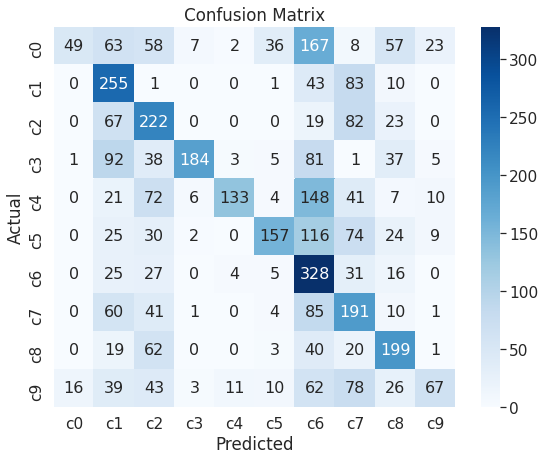

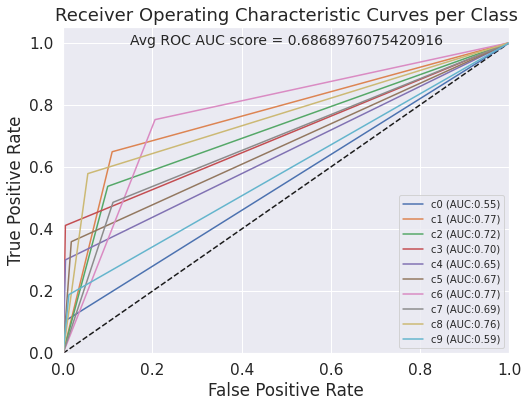

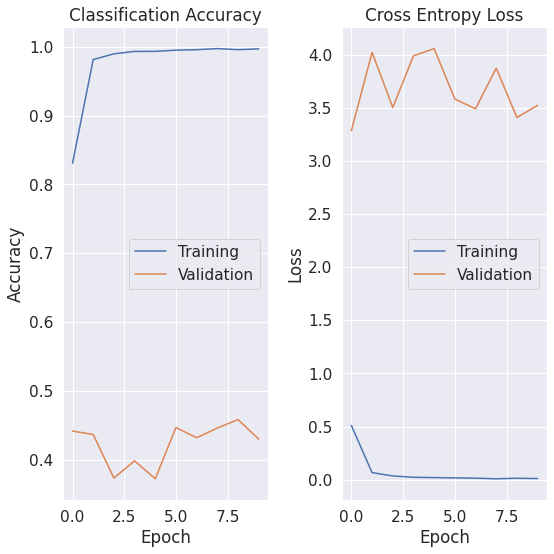

In [0]:
model_eval(model, test_batches, total_test, batch_size, classes)
plot_fit_results(history1, len(history1.history['loss']))

## Change optimizer to SGD to see if it is any better

In [0]:
opt = SGD(lr=0.005, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
train_batches.reset()
valid_batches.reset()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 238, 318, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 119, 159, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 157, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 78, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 76, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 38, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 136192)            0

Epoch 1/10
359/359 [==============================] - 79s 220ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 5.5961 - val_accuracy: 0.4253
Epoch 2/10
359/359 [==============================] - 78s 218ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 5.9358 - val_accuracy: 0.4376
Epoch 3/10
359/359 [==============================] - 78s 219ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 4.9360 - val_accuracy: 0.4198
Epoch 4/10
359/359 [==============================] - 78s 217ms/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 4.7142 - val_accuracy: 0.4696
Epoch 5/10
359/359 [==============================] - 79s 219ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 4.6714 - val_accuracy: 0.4851
Epoch 6/10
359/359 [==============================] - 78s 219ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 5.7635 - val_accuracy: 0.4358
Epoch 7/10
359/359 [==============================] - 78s 218ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 5.9854 - val_ac

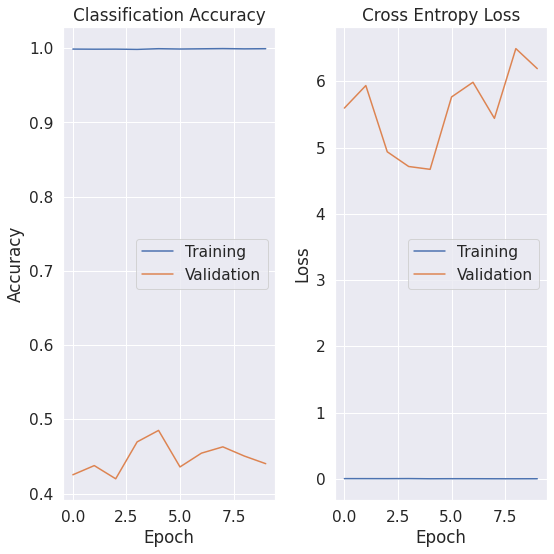

In [0]:
history1 = model.fit(x=train_batches,
                     steps_per_epoch=total_train // batch_size,
                     epochs=epochs,
                     validation_data=valid_batches,
                     validation_steps=total_val // batch_size)
plot_fit_results(history1, epochs)

104/104 [==============================] - 16s 157ms/step
              precision    recall  f1-score   support

          c0       0.32      0.08      0.13       470
          c1       0.24      0.24      0.24       393
          c2       0.28      0.46      0.35       413
          c3       0.77      0.49      0.60       447
          c4       0.58      0.38      0.46       442
          c5       0.50      0.15      0.23       437
          c6       0.32      0.73      0.45       436
          c7       0.26      0.58      0.36       393
          c8       0.37      0.26      0.31       344
          c9       0.37      0.13      0.19       355

    accuracy                           0.35      4130
   macro avg       0.40      0.35      0.33      4130
weighted avg       0.41      0.35      0.33      4130



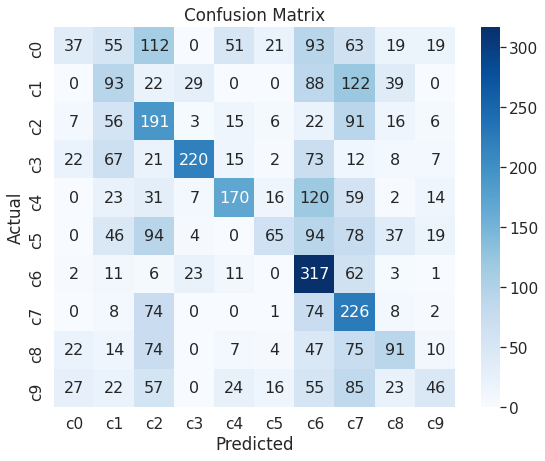

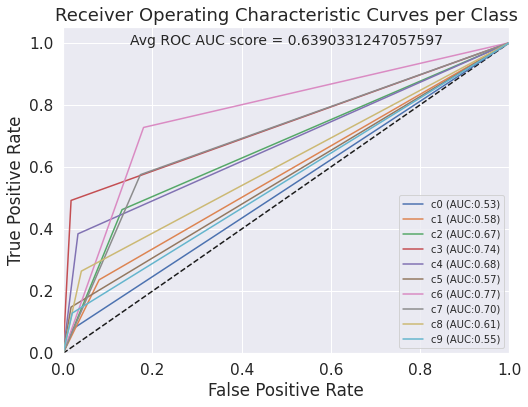

In [0]:
model_eval(model, test_batches, total_test, batch_size, classes)

#### SGD did not do any better than adam with this simple model. 

## More complex model with no augmentation
### Deeper model with more nodes, BatchNormalization, Dropout between convolution layers



In [0]:
batch_size = 32
epochs = 20
img_height = 224
img_width = 224
color_mode = 'rgb'
color_channels = 3

In [0]:
datagen = ImageDataGenerator(rescale=1./255)
train_batches, valid_batches, test_batches = create_datagen_flows(datagen, datagen, train_path, valid_path, test_path, img_height, img_width, color_mode, classes, batch_size)

Found 14387 images belonging to 10 classes.
Found 3907 images belonging to 10 classes.
Found 4130 images belonging to 10 classes.


In [0]:
model = Sequential([Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(img_height,img_width,color_channels)), 
                    Conv2D(32, kernel_size=(3, 3), activation='relu'), 
                    BatchNormalization(), 
                    MaxPooling2D(),
                    Dropout(0.3),

                    Conv2D(64, kernel_size=(3, 3), activation='relu'), 
                    Conv2D(64, kernel_size=(3, 3), activation='relu'), 
                    BatchNormalization(),
                    MaxPooling2D(),
                    Dropout(0.3),

                    Conv2D(128, kernel_size=(3, 3), activation='relu'),
                    Conv2D(128, kernel_size=(3, 3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D(),
                    Dropout(0.5),

                    GlobalAveragePooling2D(), 
                    Dense(1024, 'relu'),
                    Dropout(0.1), 
                    Dense(1024, activation='relu'), 
                    Dropout(0.5), 
                    Dense(256, activation='relu'),
                    Dense(10, activation='softmax')])

model.compile(optimizer=SGD(learning_rate=0.1), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history2 = model.fit(x=train_batches,
                     steps_per_epoch=total_train // batch_size,
                     epochs=epochs,
                     validation_data=valid_batches,
                     validation_steps=total_val // batch_size, 
                     shuffle=True, 
                     callbacks=[(early_stopping, 
                                 reduce_lr_on_plateau,
                                 model_checkpoint)])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 220, 220, 32)      9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 220, 220, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 110, 110, 32)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 106, 106, 64)     

130/130 [==============================] - 16s 120ms/step
              precision    recall  f1-score   support

          c0       0.64      0.23      0.34       470
          c1       0.64      0.55      0.59       393
          c2       0.54      0.75      0.63       413
          c3       0.74      0.50      0.60       447
          c4       0.67      0.57      0.62       442
          c5       0.35      0.22      0.27       437
          c6       0.53      0.69      0.60       436
          c7       0.32      0.42      0.37       393
          c8       0.27      0.59      0.37       344
          c9       0.39      0.29      0.33       355

    accuracy                           0.48      4130
   macro avg       0.51      0.48      0.47      4130
weighted avg       0.52      0.48      0.47      4130



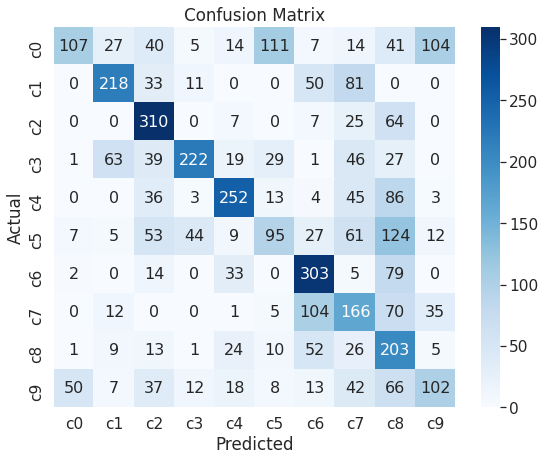

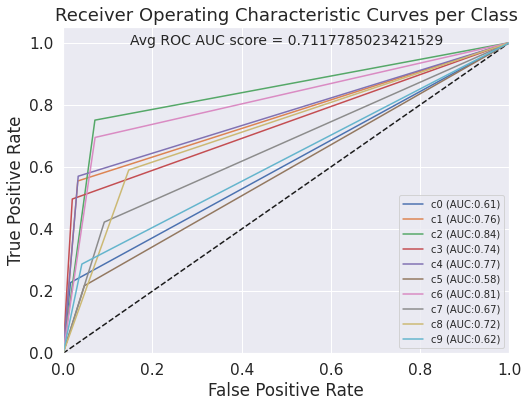

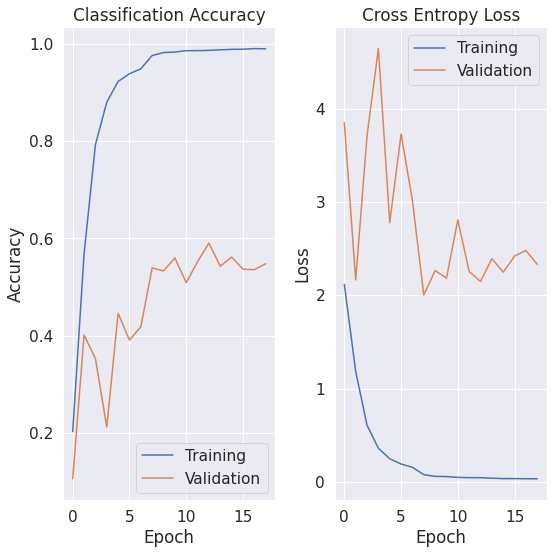

In [0]:
model_eval(model, test_batches, total_test, batch_size, classes)
plot_fit_results(history2, len(history2.history['loss']))

Note: SGD optimizer, with ReduceLROnPlateau() works best with this model, better than RMSprop and Adam. 

## Same model with image augmentation. 
#### Be careful with image manipulation:  
* distractions can be at edge of image for left hand texting and calling; and
* flipping can distort which side of body phone is on and cause incorrect class predictions. 
* Visualization of this set of augmentation parameters is in notebook 
2 - Visualize Data Augmentation.ipynb

In [0]:
batch_size = 32
epochs = 20
img_height = 224 
img_width = 224
color_mode = 'rgb'
color_channels = 3

In [21]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,  
                                   height_shift_range=0.1, 
                                   width_shift_range=0.1,
                                   shear_range=20, 
                                   zoom_range=0.2, 
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_batches, valid_batches, test_batches = create_datagen_flows(train_datagen, val_datagen, train_path, valid_path, test_path, img_height, img_width, color_mode, classes, batch_size)

Found 14387 images belonging to 10 classes.
Found 3907 images belonging to 10 classes.
Found 4130 images belonging to 10 classes.


In [22]:
model = Sequential([Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(img_height,img_width,color_channels)), 
                    Conv2D(32, kernel_size=(3, 3), activation='relu'), 
                    BatchNormalization(), 
                    MaxPooling2D(),
                    Dropout(0.3),

                    Conv2D(64, kernel_size=(3, 3), activation='relu'), 
                    Conv2D(64, kernel_size=(3, 3), activation='relu'), 
                    BatchNormalization(),
                    MaxPooling2D(),
                    Dropout(0.3),

                    Conv2D(128, kernel_size=(3, 3), activation='relu'),
                    Conv2D(128, kernel_size=(3, 3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D(),
                    Dropout(0.5),

                    GlobalAveragePooling2D(), 
                    Dense(1024, 'relu'),
                    Dropout(0.1), 
                    Dense(1024, activation='relu'), 
                    Dropout(0.5), 
                    Dense(256, activation='relu'),
                    Dense(10, activation='softmax')])


model.compile(optimizer=SGD(learning_rate=0.05), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 220, 220, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 64)      3

In [23]:
history3 = model.fit(x=train_batches,
                     steps_per_epoch=total_train // batch_size,
                     epochs=epochs,
                     validation_data=valid_batches,
                     validation_steps=total_val // batch_size, 
                     shuffle=True, 
                     callbacks=[(early_stopping, 
                                 reduce_lr_on_plateau,
                                 model_checkpoint)])

Epoch 1/20
449/449 [==============================] - ETA: 0s - loss: 2.2540 - accuracy: 0.1510
Epoch 00001: val_loss improved from inf to 2.51444, saving model to model-01-0.10.hdf5
449/449 [==============================] - 220s 491ms/step - loss: 2.2540 - accuracy: 0.1510 - val_loss: 2.5144 - val_accuracy: 0.1017 - lr: 0.0500
Epoch 2/20
449/449 [==============================] - ETA: 0s - loss: 1.7761 - accuracy: 0.3462
Epoch 00002: val_loss improved from 2.51444 to 1.64130, saving model to model-02-0.37.hdf5
449/449 [==============================] - 214s 478ms/step - loss: 1.7761 - accuracy: 0.3462 - val_loss: 1.6413 - val_accuracy: 0.3686 - lr: 0.0500
Epoch 3/20
449/449 [==============================] - ETA: 0s - loss: 1.2383 - accuracy: 0.5502
Epoch 00003: val_loss did not improve from 1.64130
449/449 [==============================] - 217s 484ms/step - loss: 1.2383 - accuracy: 0.5502 - val_loss: 1.7327 - val_accuracy: 0.5010 - lr: 0.0500
Epoch 4/20
449/449 [===================

130/130 [==============================] - 16s 124ms/step
              precision    recall  f1-score   support

          c0       0.71      0.27      0.40       470
          c1       0.59      0.80      0.68       393
          c2       0.91      0.83      0.87       413
          c3       0.78      0.45      0.57       447
          c4       0.93      0.44      0.60       442
          c5       0.94      0.30      0.46       437
          c6       0.30      0.94      0.45       436
          c7       0.65      0.36      0.46       393
          c8       0.52      0.24      0.33       344
          c9       0.36      0.69      0.47       355

    accuracy                           0.53      4130
   macro avg       0.67      0.53      0.53      4130
weighted avg       0.68      0.53      0.53      4130



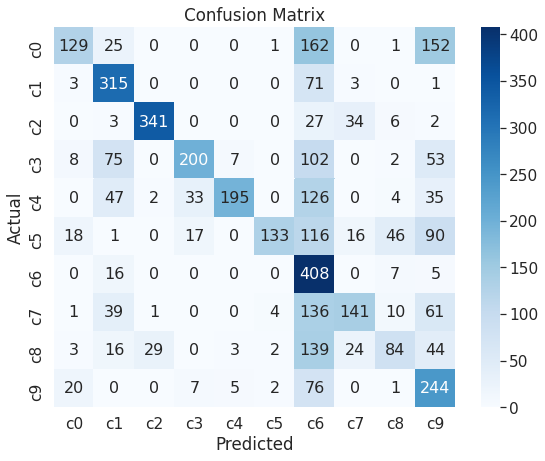

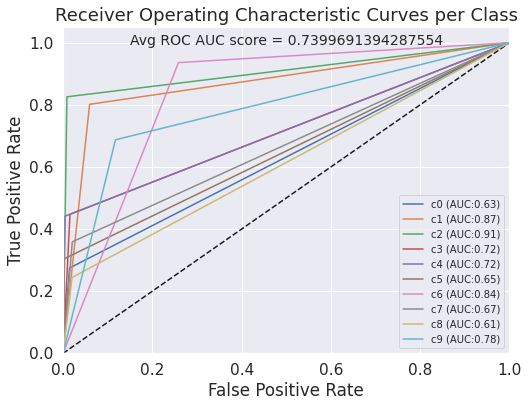

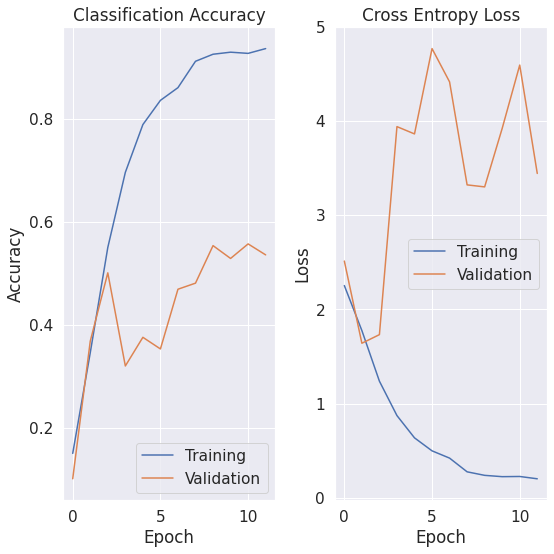

In [24]:
model_eval(model, test_batches, total_test, batch_size, classes)
plot_fit_results(history3, len(history3.history['loss']))

## Transfer learning


In [0]:
img_height = 224
img_width = 224
color_channels = 3
color_mode = 'rgb'
img_shape = (img_height, img_width, color_channels)
epochs=30
batch_size = 32

### ResNet50

In [0]:
train_datagen = ImageDataGenerator(height_shift_range=0.1,
                                   width_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=30,
                                   fill_mode='nearest', 
                                   preprocessing_function=resnet.preprocess_input)
datagen = ImageDataGenerator(preprocessing_function=resnet.preprocess_input)
train_batches, valid_batches, test_batches = create_datagen_flows(train_datagen, datagen, train_path, valid_path, test_path, img_height, img_width, color_mode, classes, batch_size)

Found 14387 images belonging to 10 classes.
Found 3907 images belonging to 10 classes.
Found 4130 images belonging to 10 classes.


In [0]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)
resnet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
resnet_base.trainable = False
global_average = GlobalAveragePooling2D()
dense_1 = Dense(1024, activation='relu')
dropout_1 = Dropout(0.1)
dense_2 = Dense(1024, activation='relu')
batchnorm_2 = BatchNormalization()
dropout_2 =  Dropout(0.5)
dense_3 = Dense(512, activation='relu')
output = Dense(10, activation='softmax')
resnet_model = Sequential([resnet_base,
                           global_average,
                           dense_1, 
                           dropout_1, 
                           dense_2, 
                           batchnorm_2, 
                           dropout_2, 
                           dense_3,
                           output])

In [0]:
sgd = SGD(lr = 0.001)
resnet_model.compile(optimizer=sgd,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0

#### First, train the new layers. 

In [0]:
resnet_history = resnet_model.fit(train_batches, 
                                  steps_per_epoch=total_train//batch_size, 
                                  epochs=epochs, 
                                  validation_data=valid_batches, 
                                  validation_steps=total_val//batch_size, 
                                  shuffle=True,
                                  callbacks=[(early_stopping, 
                                              model_checkpoint, 
                                              reduce_lr_on_plateau)])

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 2.2489 - accuracy: 0.2492
Epoch 00001: val_loss improved from inf to 1.60728, saving model to model-01-0.44.hdf5
449/449 [==============================] - 205s 457ms/step - loss: 2.2489 - accuracy: 0.2492 - val_loss: 1.6073 - val_accuracy: 0.4419 - lr: 0.0010
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 1.6140 - accuracy: 0.4415
Epoch 00002: val_loss improved from 1.60728 to 1.26539, saving model to model-02-0.55.hdf5
449/449 [==============================] - 206s 458ms/step - loss: 1.6140 - accuracy: 0.4415 - val_loss: 1.2654 - val_accuracy: 0.5489 - lr: 0.0010
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 1.3047 - accuracy: 0.5492
Epoch 00003: val_loss improved from 1.26539 to 1.14102, saving model to model-03-0.57.hdf5
449/449 [==============================] - 206s 458ms/step - loss: 1.3047 - accuracy: 0.5492 - val_loss: 1.1410 - val_accuracy: 0.5720 - lr: 0.0010

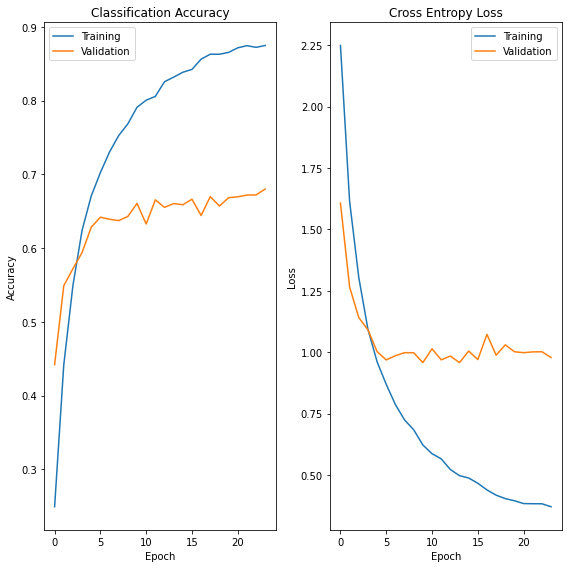

In [0]:
plot_fit_results(resnet_history, len(resnet_history.history['loss']))

130/130 [==============================] - 18s 139ms/step
              precision    recall  f1-score   support

          c0       0.73      0.66      0.69       470
          c1       0.77      0.65      0.71       393
          c2       0.76      0.65      0.70       413
          c3       0.80      0.90      0.85       447
          c4       0.82      0.75      0.78       442
          c5       0.74      0.95      0.83       437
          c6       0.72      0.77      0.74       436
          c7       0.73      0.86      0.79       393
          c8       0.47      0.56      0.51       344
          c9       0.55      0.32      0.41       355

    accuracy                           0.72      4130
   macro avg       0.71      0.71      0.70      4130
weighted avg       0.72      0.72      0.71      4130



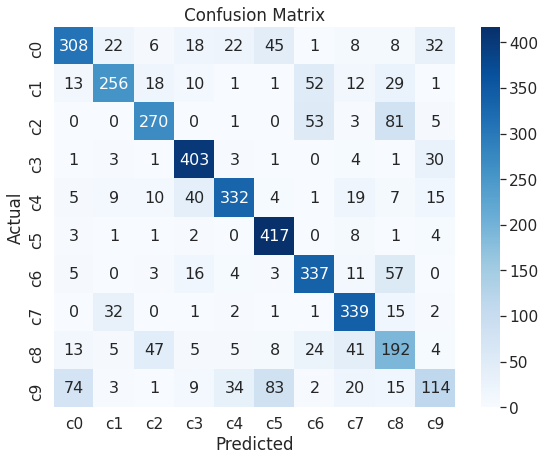

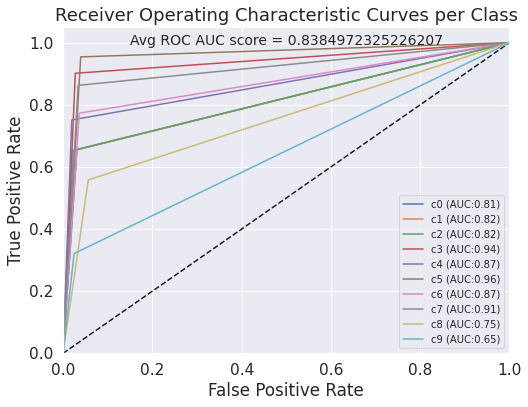

In [0]:
model_eval(resnet_model, test_batches, total_test, batch_size, classes)

#### Now fine-tune last two Conv blocks.

In [0]:
change_layers = [layer for layer in resnet_base.layers if (layer.name.startswith('conv4') | layer.name.startswith('conv5'))]
for layer in change_layers:
    layer.trainable = True

sgd = SGD(lr=5.0000e-05)
resnet_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
resnet_hist_fine = resnet_model.fit(train_batches, 
                               steps_per_epoch=total_train//batch_size, 
                               epochs=epochs, 
                               validation_data=valid_batches, 
                               validation_steps=total_val//batch_size, 
                               shuffle=True,
                               callbacks=[(early_stopping, 
                                           model_checkpoint, 
                                           reduce_lr_on_plateau)] 
)

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 1.3095 - accuracy: 0.5619
Epoch 00001: val_loss did not improve from 0.95770
449/449 [==============================] - 202s 451ms/step - loss: 1.3095 - accuracy: 0.5619 - val_loss: 1.2817 - val_accuracy: 0.6345 - lr: 5.0000e-05
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 1.2307 - accuracy: 0.5850
Epoch 00002: val_loss did not improve from 0.95770
449/449 [==============================] - 202s 450ms/step - loss: 1.2307 - accuracy: 0.5850 - val_loss: 1.3014 - val_accuracy: 0.6340 - lr: 5.0000e-05
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 1.1725 - accuracy: 0.5997
Epoch 00003: val_loss did not improve from 0.95770
449/449 [==============================] - 201s 449ms/step - loss: 1.1725 - accuracy: 0.5997 - val_loss: 1.3196 - val_accuracy: 0.6342 - lr: 5.0000e-05
Epoch 4/30
449/449 [==============================] - ETA: 0s - loss: 1.1595 - accuracy: 0.6114
Epoch 0

130/130 [==============================] - 18s 138ms/step
              precision    recall  f1-score   support

          c0       0.62      0.53      0.57       470
          c1       0.75      0.24      0.37       393
          c2       0.42      1.00      0.59       413
          c3       0.98      0.71      0.82       447
          c4       0.91      0.61      0.73       442
          c5       0.66      0.95      0.77       437
          c6       0.80      0.66      0.72       436
          c7       0.88      0.70      0.78       393
          c8       0.47      0.55      0.50       344
          c9       0.44      0.36      0.40       355

    accuracy                           0.64      4130
   macro avg       0.69      0.63      0.63      4130
weighted avg       0.70      0.64      0.63      4130



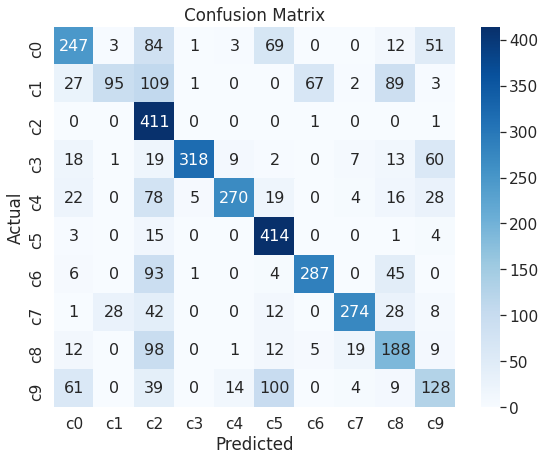

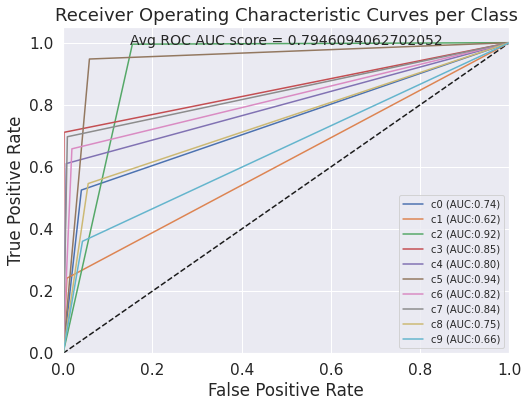

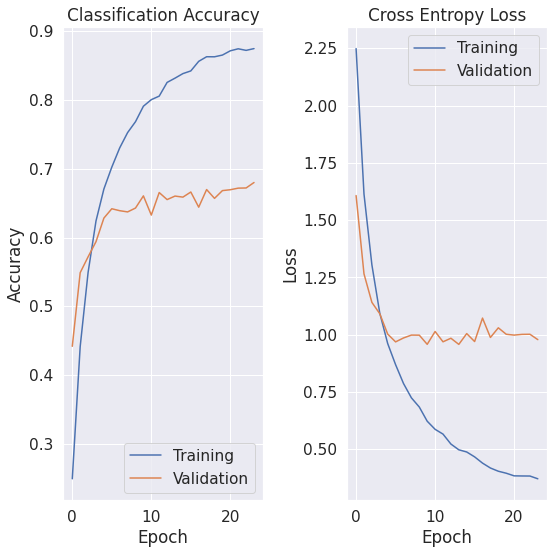

In [0]:
model_eval(resnet_model, test_batches, total_test, batch_size, classes)
plot_fit_results(resnet_history, len(resnet_history.history['loss']))

#### Try training just the output block with a simplified output. 

In [0]:
train_batches.reset()
valid_batches.reset()
test_batches.reset()
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)
resnet_base.trainable = False
global_average = GlobalAveragePooling2D()
output = Dense(10, activation='softmax')
resnet_model = Sequential([resnet_base,
                           global_average,
                           output])

In [0]:
sgd = SGD(lr = 0.001)
resnet_model.compile(optimizer=sgd,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
resnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
resnet_history = resnet_model.fit(train_batches, 
                                  steps_per_epoch=total_train//batch_size, 
                                  epochs=epochs, 
                                  validation_data=valid_batches, 
                                  validation_steps=total_val//batch_size, 
                                  shuffle=True,
                                  callbacks=[(early_stopping, 
                                              model_checkpoint, 
                                              reduce_lr_on_plateau)])

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 2.1451 - accuracy: 0.2375
Epoch 00001: val_loss did not improve from 1.11996
449/449 [==============================] - 225s 501ms/step - loss: 2.1451 - accuracy: 0.2375 - val_loss: 2.0035 - val_accuracy: 0.2797 - lr: 0.0010
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 1.6866 - accuracy: 0.4481
Epoch 00002: val_loss did not improve from 1.11996
449/449 [==============================] - 223s 498ms/step - loss: 1.6866 - accuracy: 0.4481 - val_loss: 1.6814 - val_accuracy: 0.4078 - lr: 0.0010
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 1.4321 - accuracy: 0.5695
Epoch 00003: val_loss did not improve from 1.11996
449/449 [==============================] - 223s 496ms/step - loss: 1.4321 - accuracy: 0.5695 - val_loss: 1.5268 - val_accuracy: 0.4588 - lr: 0.0010
Epoch 4/30
449/449 [==============================] - ETA: 0s - loss: 1.2666 - accuracy: 0.6309
Epoch 00004: val_lo

130/130 [==============================] - 20s 155ms/step
              precision    recall  f1-score   support

          c0       0.68      0.79      0.73       470
          c1       0.75      0.58      0.65       393
          c2       0.70      0.66      0.68       413
          c3       0.92      0.84      0.88       447
          c4       0.86      0.79      0.82       442
          c5       0.80      0.90      0.85       437
          c6       0.69      0.83      0.75       436
          c7       0.90      0.75      0.82       393
          c8       0.42      0.66      0.51       344
          c9       0.58      0.32      0.41       355

    accuracy                           0.72      4130
   macro avg       0.73      0.71      0.71      4130
weighted avg       0.74      0.72      0.72      4130



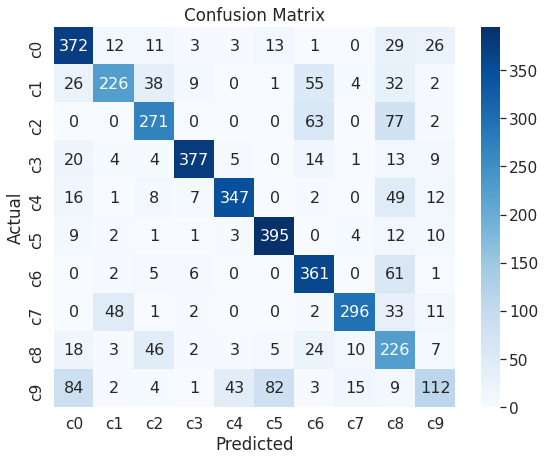

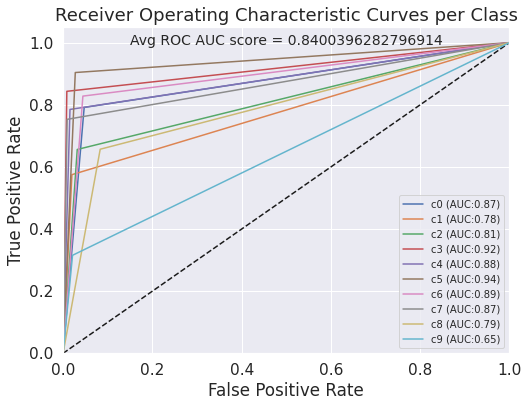

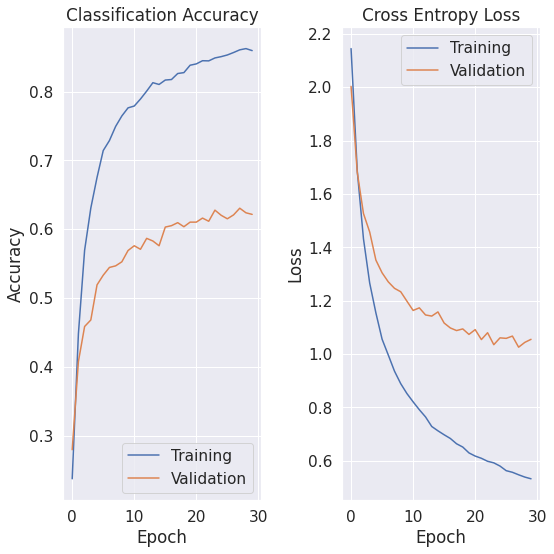

In [0]:
model_eval(resnet_model, test_batches, total_test, batch_size, classes)
plot_fit_results(resnet_history, len(resnet_history.history['loss']))

#### Now try fine-tuning entire Resnet model at once instead of two-stage training.  

Use alternate data augmentation. Numbers from notebook resulted in slightly worse performance. 

In [0]:
train_datagen = ImageDataGenerator(height_shift_range=0.1,
                                   width_shift_range = 0.1,
                                   zoom_range = 0.2,
                                   rotation_range=30,
                                   fill_mode='nearest', 
                                   preprocessing_function=resnet.preprocess_input)
datagen = ImageDataGenerator(preprocessing_function=resnet.preprocess_input)
train_batches, valid_batches, test_batches = create_datagen_flows(train_datagen, datagen, train_path, valid_path, test_path, img_height, img_width, color_mode, classes, batch_size)

Found 14387 images belonging to 10 classes.
Found 3907 images belonging to 10 classes.
Found 4130 images belonging to 10 classes.


In [0]:
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)
resnet_base.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [0]:
resnet_base.trainable = True
global_average = GlobalAveragePooling2D()
dense_1 = Dense(1024, activation='relu')
dropout_1 = Dropout(0.1)
dense_2 = Dense(1024, activation='relu')
batchnorm_2 = BatchNormalization()
dropout_2 =  Dropout(0.5)
dense_3 = Dense(512, activation='relu')
output = Dense(10, activation='softmax')
resnet_model = Sequential([resnet_base,
                           global_average,
                           dense_1, 
                           dropout_1, 
                           dense_2, 
                           batchnorm_2, 
                           dropout_2, 
                           dense_3,
                           output])

In [0]:
sgd = SGD(lr = 0.001)
resnet_model.compile(optimizer=sgd,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)             

In [0]:
resnet_all_history = resnet_model.fit(train_batches, 
                                  steps_per_epoch=total_train//batch_size, 
                                  epochs=epochs, 
                                  validation_data=valid_batches, 
                                  validation_steps=total_val//batch_size, 
                                  shuffle=True,
                                  callbacks=[(early_stopping, 
                                              model_checkpoint, 
                                              learning_rate_scheduler)])

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 1.9288 - accuracy: 0.3704
Epoch 00001: val_loss did not improve from 0.50171
449/449 [==============================] - 221s 492ms/step - loss: 1.9288 - accuracy: 0.3704 - val_loss: 1.2898 - val_accuracy: 0.5620 - lr: 0.0010
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.7987
Epoch 00002: val_loss did not improve from 0.50171
449/449 [==============================] - 221s 492ms/step - loss: 0.6439 - accuracy: 0.7987 - val_loss: 0.8000 - val_accuracy: 0.7387 - lr: 0.0010
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 0.3366 - accuracy: 0.8972
Epoch 00003: val_loss did not improve from 0.50171
449/449 [==============================] - 220s 490ms/step - loss: 0.3366 - accuracy: 0.8972 - val_loss: 0.6472 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 4/30
449/449 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.9326
Epoch 00004: val_lo

#### Test set performace

130/130 [==============================] - 18s 137ms/step
              precision    recall  f1-score   support

          c0       0.66      0.76      0.70       470
          c1       1.00      0.93      0.96       393
          c2       0.92      0.99      0.95       413
          c3       0.96      0.97      0.96       447
          c4       0.98      0.85      0.91       442
          c5       0.92      0.97      0.95       437
          c6       0.97      0.89      0.93       436
          c7       0.95      0.97      0.96       393
          c8       0.62      0.81      0.70       344
          c9       0.73      0.47      0.57       355

    accuracy                           0.87      4130
   macro avg       0.87      0.86      0.86      4130
weighted avg       0.87      0.87      0.87      4130



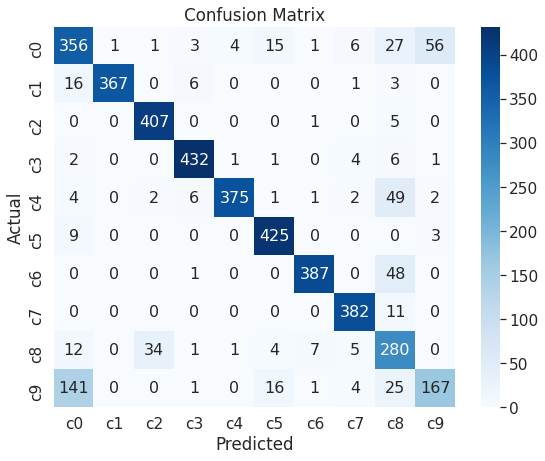

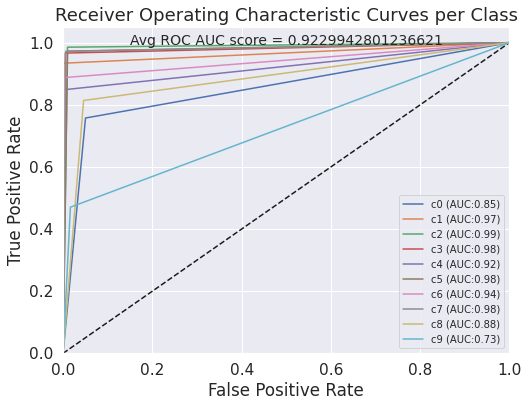

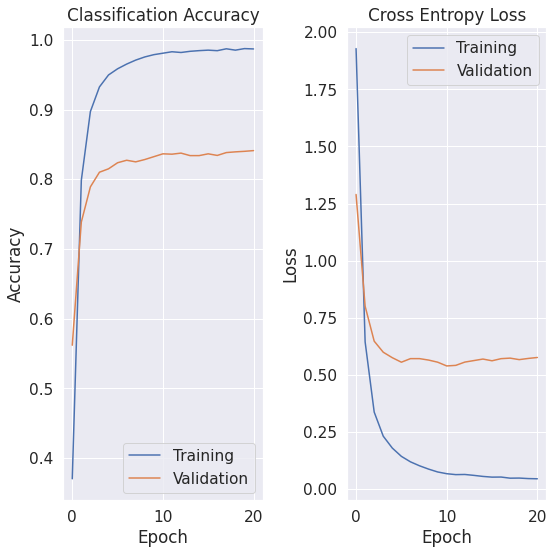

In [0]:
model_eval(resnet_model, test_batches, total_test, batch_size, classes)
plot_fit_results(resnet_all_history, len(resnet_all_history.history['loss']))

#### Try fine-tuning with simple output block.

In [0]:
train_batches.reset()
valid_batches.reset()
test_batches.reset()
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)
resnet_base.trainable = True
global_average = GlobalAveragePooling2D()
output = Dense(10, activation='softmax')
resnet_model = Sequential([resnet_base,
                           global_average,
                           output])

In [0]:
sgd = SGD(lr = 0.001)
resnet_model.compile(optimizer=sgd,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
resnet_model.summary()
resnet_all_history = resnet_model.fit(train_batches, 
                                  steps_per_epoch=total_train//batch_size, 
                                  epochs=epochs, 
                                  validation_data=valid_batches, 
                                  validation_steps=total_val//batch_size, 
                                  shuffle=True,
                                  callbacks=[(early_stopping, 
                                              model_checkpoint, 
                                              learning_rate_scheduler)])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 1.7040 - accuracy: 0.4798
Epoch 00001: val_loss improved from inf to 1.34685, saving model to model-01-0.58.hdf5
449/449 [==============================] - 224s 499ms/step - loss: 1.7040 - accuracy: 0.4798 - val_loss: 1.3468 - val_accuracy: 0.5809 - lr: 0.0010
Epoch 2/30
449/449 [==================

130/130 [==============================] - 19s 142ms/step
              precision    recall  f1-score   support

          c0       0.76      0.75      0.75       470
          c1       1.00      0.98      0.99       393
          c2       0.97      0.96      0.97       413
          c3       0.95      0.97      0.96       447
          c4       0.99      0.83      0.90       442
          c5       0.89      0.91      0.90       437
          c6       0.99      0.74      0.85       436
          c7       0.99      0.81      0.89       393
          c8       0.46      0.92      0.61       344
          c9       0.69      0.50      0.58       355

    accuracy                           0.84      4130
   macro avg       0.87      0.84      0.84      4130
weighted avg       0.88      0.84      0.85      4130



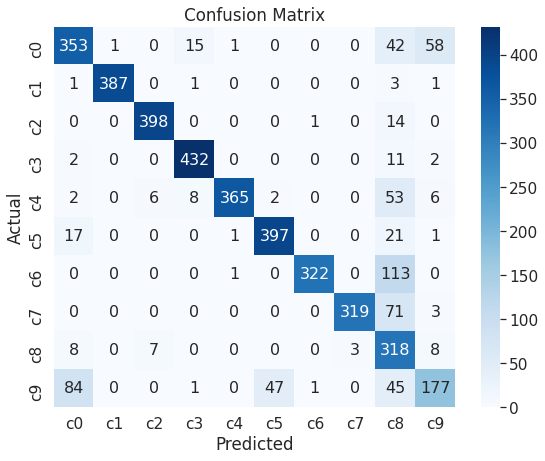

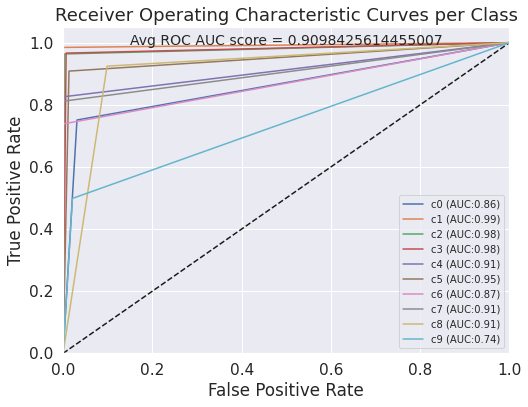

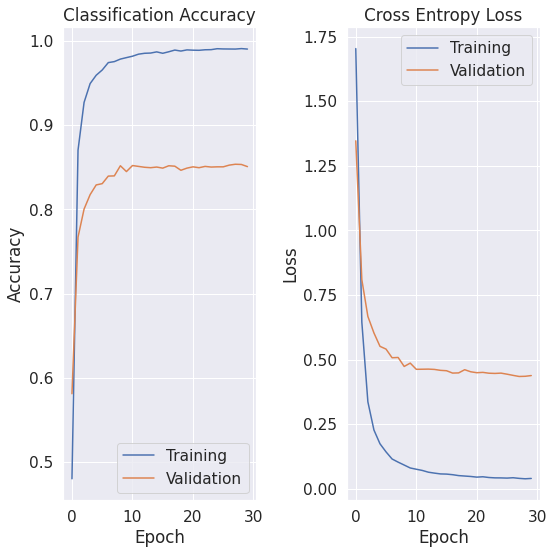

In [0]:
model_eval(resnet_model, test_batches, total_test, batch_size, classes)
plot_fit_results(resnet_all_history, len(resnet_all_history.history['loss']))

#### One more time with Flatten() instead of GlobalAveragePooling2D().

In [0]:
train_batches.reset()
valid_batches.reset()
test_batches.reset()
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=img_shape)
resnet_base.trainable = True
global_average = Flatten()
output = Dense(10, activation='softmax')
resnet_model = Sequential([resnet_base,
                           global_average,
                           output])

In [0]:
sgd = SGD(lr = 0.001)
resnet_model.compile(optimizer=sgd,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
resnet_model.summary()
resnet_all_history = resnet_model.fit(train_batches, 
                                  steps_per_epoch=total_train//batch_size, 
                                  epochs=epochs, 
                                  validation_data=valid_batches, 
                                  validation_steps=total_val//batch_size, 
                                  shuffle=True,
                                  callbacks=[(early_stopping, 
                                              model_checkpoint, 
                                              learning_rate_scheduler)])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1003530   
Total params: 24,591,242
Trainable params: 24,538,122
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 0.1917 - accuracy: 0.9493
Epoch 00001: val_loss did not improve from 0.43442
449/449 [==============================] - 228s 508ms/step - loss: 0.1917 - accuracy: 0.9493 - val_loss: 0.8772 - val_accuracy: 0.8404 - lr: 0.0010
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 0.

130/130 [==============================] - 18s 136ms/step
              precision    recall  f1-score   support

          c0       0.64      0.74      0.69       470
          c1       1.00      0.94      0.97       393
          c2       0.95      0.87      0.91       413
          c3       0.95      0.96      0.96       447
          c4       0.98      0.82      0.89       442
          c5       0.94      0.87      0.90       437
          c6       0.99      0.66      0.79       436
          c7       0.98      0.70      0.82       393
          c8       0.38      0.95      0.54       344
          c9       0.78      0.35      0.49       355

    accuracy                           0.79      4130
   macro avg       0.86      0.79      0.80      4130
weighted avg       0.87      0.79      0.80      4130



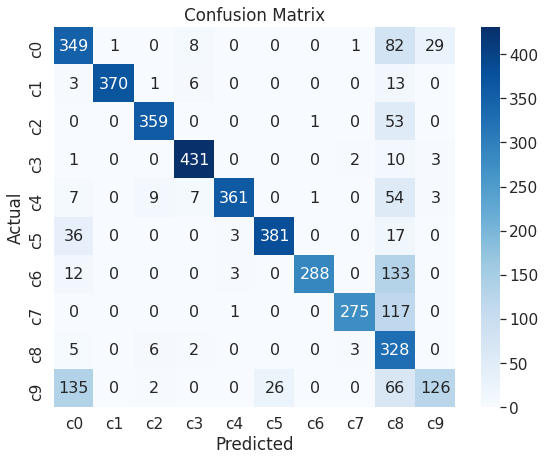

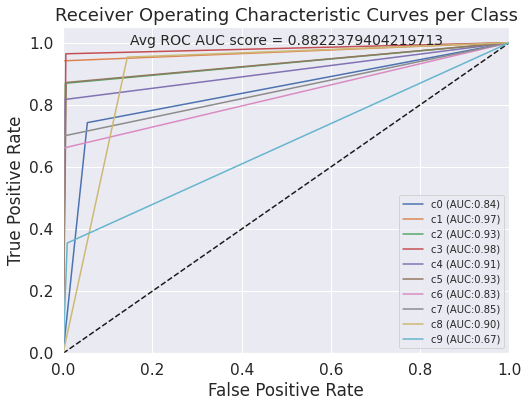

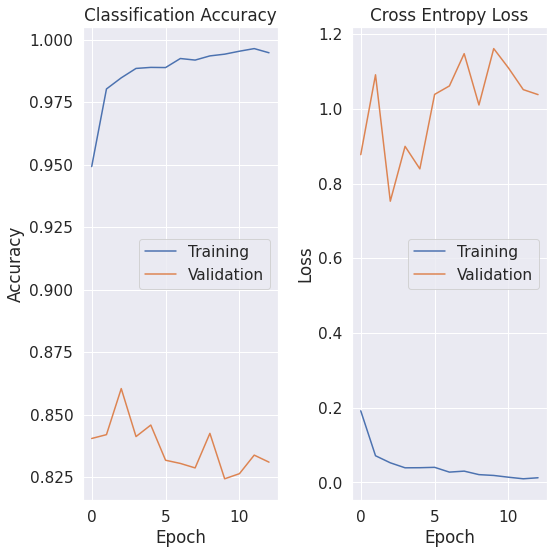

In [0]:
model_eval(resnet_model, test_batches, total_test, batch_size, classes)
plot_fit_results(resnet_all_history, len(resnet_all_history.history['loss']))

1) No image preprocessing:
ResNet with all layers frozen did worse with Augmented Data (rescale=1./255, 
                                   rotation_range=20,  
                                   height_shift_range=0.1, 
                                   width_shift_range=0.1,
                                   shear_range=10, 
                                   zoom_range=0.2, 
                                   fill_mode='nearest') 
than it did with normalized data that was unaugmented.   
Using adam w default lr, stalled around .27 accuracy. Switched to SGD with low rate, learning progressed.   

2) With image preprocessing:  
ResNet with all layers frozen, no augmented data: val_acc = .476  
read article recommending different model as ResNet overfits with small amount of data (10K images). This dataset has slightly more than that.   

3) Tried again with smaller learning_rate, read a blog that this data is complex, does better with small learning rates.  Training new output only, then fine-tuning model yields poor results even w smaller learning rates.  

4) Tried simple output block, works better when tuning entire model. Better accuracy, lower loss.   

5) Compared GlobalAveragePooling2D() and Flatten(), GAP yielded significantly lower loss (.44 vs 1.0) and slightly better accuracy (.85 vs .83). 



### MobileNet V2

In [0]:
img_height = 224
img_width = 224
color_channels = 3
color_mode = 'rgb'
img_shape = (img_height, img_width, color_channels)
epochs=30
batch_size = 32

In [0]:
train_datagen = ImageDataGenerator(height_shift_range=0.1,
                                   width_shift_range = 0.1,
                                   zoom_range = 0.2,
                                   rotation_range=30,
                                   fill_mode='nearest', 
                                   preprocessing_function=mobilenet_v2.preprocess_input)
datagen = ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)
train_batches, valid_batches, test_batches = create_datagen_flows(train_datagen, datagen, train_path, valid_path, test_path, img_height, img_width, color_mode, classes, batch_size)

Found 14387 images belonging to 10 classes.
Found 3907 images belonging to 10 classes.
Found 4130 images belonging to 10 classes.


In [0]:
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_shape)
mobilenet_base.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [0]:
mobilenet_base.trainable = False
global_average = GlobalAveragePooling2D()
dense_1 = Dense(1024, activation='relu')
dropout_1 = Dropout(0.1)
dense_2 = Dense(1024, activation='relu')
batchnorm_2 = BatchNormalization()
dropout_2 =  Dropout(0.5)
dense_3 = Dense(512, activation='relu')
output = Dense(10, activation='softmax')
mobilenet_model = Sequential([mobilenet_base,
                              global_average,
                              dense_1, 
                              dropout_1, 
                              dense_2, 
                              batchnorm_2, 
                              dropout_2, 
                              dense_3,
                              output])

In [0]:
sgd = SGD(lr = 0.001)
mobilenet_model.compile(optimizer=sgd,
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0

#### First, train the new layers. 

In [0]:
mobilenet_history = mobilenet_model.fit(train_batches, 
                                        steps_per_epoch=total_train//batch_size, 
                                        epochs=epochs, 
                                        validation_data=valid_batches, 
                                        validation_steps=total_val//batch_size, 
                                        shuffle=True,
                                        callbacks=[(early_stopping, 
                                                    model_checkpoint, 
                                                    learning_rate_scheduler)])

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 2.3619 - accuracy: 0.2102
Epoch 00001: val_loss improved from inf to 1.87887, saving model to model-01-0.30.hdf5
449/449 [==============================] - 225s 501ms/step - loss: 2.3619 - accuracy: 0.2102 - val_loss: 1.8789 - val_accuracy: 0.2999 - lr: 0.0010
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 1.7371 - accuracy: 0.3902
Epoch 00002: val_loss improved from 1.87887 to 1.64764, saving model to model-02-0.39.hdf5
449/449 [==============================] - 220s 489ms/step - loss: 1.7371 - accuracy: 0.3902 - val_loss: 1.6476 - val_accuracy: 0.3909 - lr: 0.0010
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 1.4093 - accuracy: 0.5112
Epoch 00003: val_loss improved from 1.64764 to 1.53485, saving model to model-03-0.42.hdf5
449/449 [==============================] - 217s 484ms/step - loss: 1.4093 - accuracy: 0.5112 - val_loss: 1.5349 - val_accuracy: 0.4239 - lr: 0.0010

130/130 [==============================] - 18s 135ms/step
              precision    recall  f1-score   support

          c0       0.60      0.72      0.66       470
          c1       0.77      0.59      0.67       393
          c2       0.54      0.90      0.67       413
          c3       0.81      0.79      0.80       447
          c4       0.64      0.74      0.68       442
          c5       0.78      0.66      0.72       437
          c6       0.75      0.66      0.70       436
          c7       0.76      0.62      0.68       393
          c8       0.37      0.44      0.40       344
          c9       0.43      0.18      0.26       355

    accuracy                           0.64      4130
   macro avg       0.65      0.63      0.62      4130
weighted avg       0.65      0.64      0.64      4130



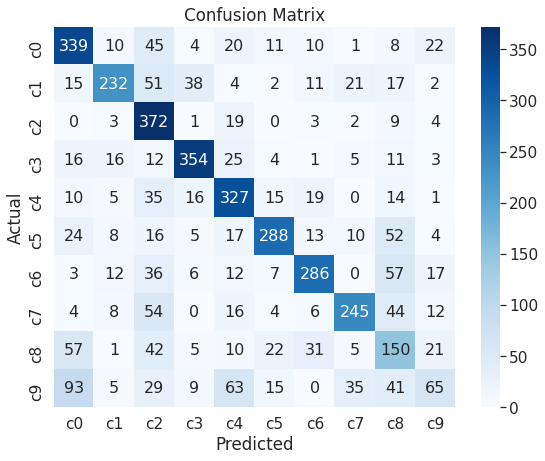

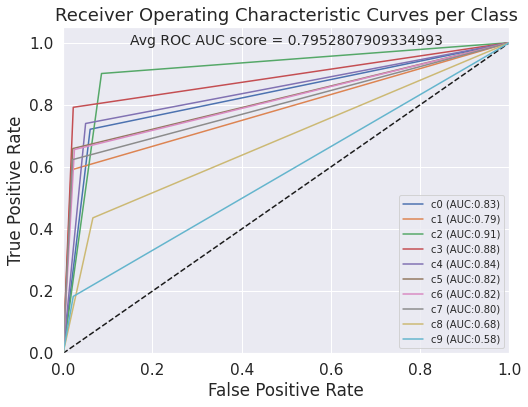

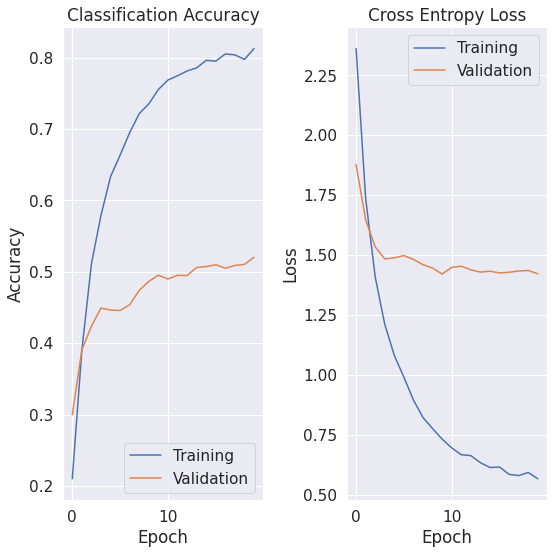

In [0]:
model_eval(mobilenet_model, test_batches, total_test, batch_size, classes)
plot_fit_results(mobilenet_history, len(mobilenet_history.history['loss']))

#### Now fine-tune the whole mobilenet.

In [0]:
mobilenet_base.trainable = True

sgd = SGD(lr=5.0000e-04)
mobilenet_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
mobilenet_hist_fine = mobilenet_model.fit(train_batches, 
                                          steps_per_epoch=total_train//batch_size, 
                                          epochs=epochs, 
                                          validation_data=valid_batches, 
                                          validation_steps=total_val//batch_size, 
                                          shuffle=True,
                                          callbacks=[(early_stopping, 
                                                     model_checkpoint, 
                                                     reduce_lr_on_plateau)])

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 1.9322 - accuracy: 0.3813
Epoch 00001: val_loss did not improve from 1.42148
449/449 [==============================] - 224s 498ms/step - loss: 1.9322 - accuracy: 0.3813 - val_loss: 1.9300 - val_accuracy: 0.4951 - lr: 5.0000e-04
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 1.6726 - accuracy: 0.4437
Epoch 00002: val_loss did not improve from 1.42148
449/449 [==============================] - 218s 486ms/step - loss: 1.6726 - accuracy: 0.4437 - val_loss: 1.8750 - val_accuracy: 0.4997 - lr: 5.0000e-04
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 1.5328 - accuracy: 0.4889
Epoch 00003: val_loss did not improve from 1.42148
449/449 [==============================] - 216s 481ms/step - loss: 1.5328 - accuracy: 0.4889 - val_loss: 1.8980 - val_accuracy: 0.4985 - lr: 5.0000e-04
Epoch 4/30
449/449 [==============================] - ETA: 0s - loss: 1.4341 - accuracy: 0.5149
Epoch 0

130/130 [==============================] - 17s 132ms/step
              precision    recall  f1-score   support

          c0       0.56      0.26      0.35       470
          c1       0.59      0.35      0.44       393
          c2       0.24      0.99      0.38       413
          c3       1.00      0.20      0.33       447
          c4       0.46      0.44      0.45       442
          c5       0.45      0.78      0.57       437
          c6       0.67      0.65      0.66       436
          c7       0.92      0.31      0.46       393
          c8       0.34      0.04      0.07       344
          c9       0.42      0.12      0.19       355

    accuracy                           0.42      4130
   macro avg       0.57      0.41      0.39      4130
weighted avg       0.57      0.42      0.40      4130



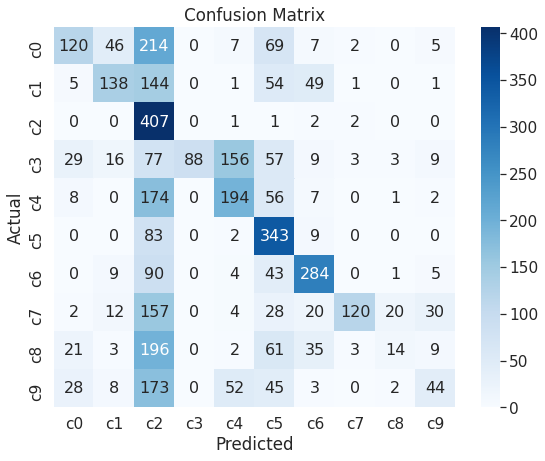

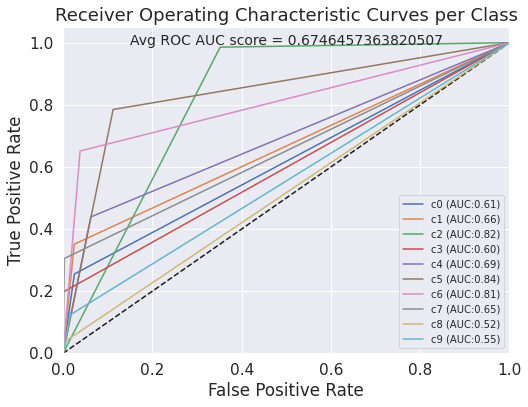

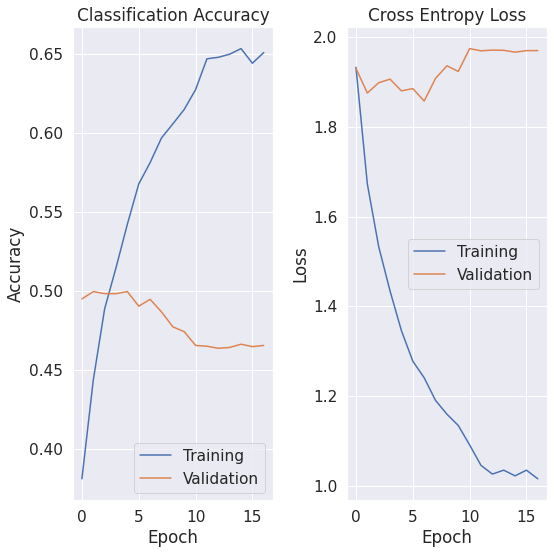

In [0]:
model_eval(mobilenet_model, test_batches, total_test, batch_size, classes)
plot_fit_results(mobilenet_hist_fine, len(mobilenet_hist_fine.history['loss']))

#### Try tuning the whole mobilenet model from the beginning instead of just the output layer first. 

In [0]:
train_batches.reset()
valid_batches.reset()
test_batches.reset()
mobilenet_base.trainable = True
global_average = GlobalAveragePooling2D()
dense_1 = Dense(1024, activation='relu')
dropout_1 = Dropout(0.1)
dense_2 = Dense(1024, activation='relu')
batchnorm_2 = BatchNormalization()
dropout_2 =  Dropout(0.5)
dense_3 = Dense(512, activation='relu')
output = Dense(10, activation='softmax')
mobilenet_model = Sequential([mobilenet_base,
                              global_average,
                              dense_1, 
                              dropout_1, 
                              dense_2, 
                              batchnorm_2, 
                              dropout_2, 
                              dense_3,
                              output])
sgd = SGD(lr = 0.001)
mobilenet_model.compile(optimizer=sgd,
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
mobilenet_model.summary()
mobilenet_history = mobilenet_model.fit(train_batches, 
                                        steps_per_epoch=total_train//batch_size, 
                                        epochs=epochs, 
                                        validation_data=valid_batches, 
                                        validation_steps=total_val//batch_size, 
                                        shuffle=True,
                                        callbacks=[(early_stopping, 
                                                   model_checkpoint, 
                                                   learning_rate_scheduler)])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)             

#### Test set performance

130/130 [==============================] - 17s 128ms/step
              precision    recall  f1-score   support

          c0       0.65      0.78      0.71       470
          c1       0.97      0.91      0.94       393
          c2       0.94      0.92      0.93       413
          c3       0.88      0.94      0.91       447
          c4       0.94      0.83      0.88       442
          c5       0.95      0.95      0.95       437
          c6       0.92      0.81      0.86       436
          c7       0.71      0.98      0.82       393
          c8       0.66      0.72      0.69       344
          c9       0.62      0.32      0.43       355

    accuracy                           0.82      4130
   macro avg       0.82      0.82      0.81      4130
weighted avg       0.83      0.82      0.82      4130



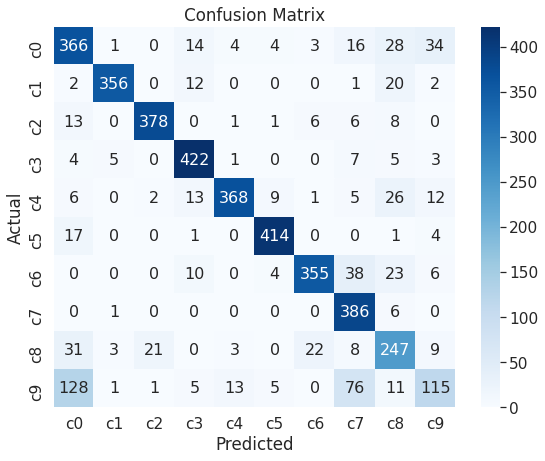

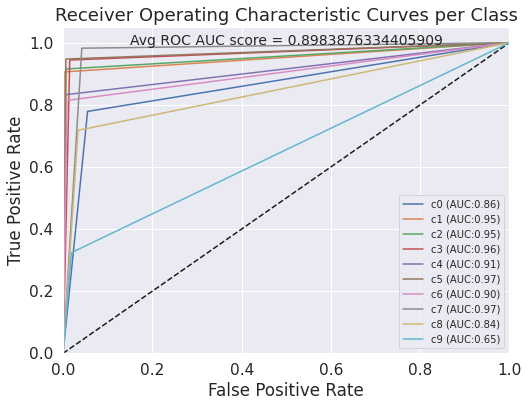

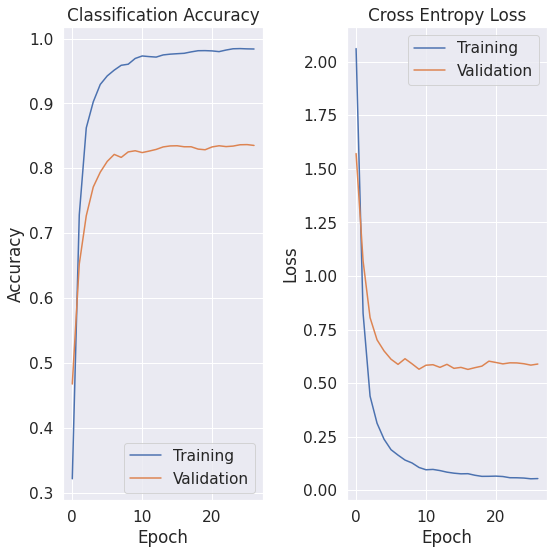

In [0]:
model_eval(mobilenet_model, test_batches, total_test, batch_size, classes)
plot_fit_results(mobilenet_history, len(mobilenet_history.history['loss']))

#### Try again with simple output block. 

In [0]:
train_batches.reset()
valid_batches.reset()
test_batches.reset()
mobilenet_base.trainable = True
global_average = GlobalAveragePooling2D()
output = Dense(10, activation='softmax')
mobilenet_model = Sequential([mobilenet_base,
                              global_average,
                              output])
sgd = SGD(lr = 0.001)
mobilenet_model.compile(optimizer=sgd,
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
mobilenet_model.summary()
mobilenet_history = mobilenet_model.fit(train_batches, 
                                        steps_per_epoch=total_train//batch_size, 
                                        epochs=epochs, 
                                        validation_data=valid_batches, 
                                        validation_steps=total_val//batch_size, 
                                        shuffle=True,
                                        callbacks=[(early_stopping, 
                                                   model_checkpoint, 
                                                   learning_rate_scheduler)])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                12810     
Total params: 2,270,794
Trainable params: 2,236,682
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 1.7918 - accuracy: 0.4278
Epoch 00001: val_loss did not improve from 0.43442
449/449 [==============================] - 224s 498ms/step - loss: 1.7918 - accuracy: 0.4278 - val_loss: 1.9491 - val_accuracy: 0.2848 - lr: 0.0010
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 0.80

130/130 [==============================] - 15s 113ms/step
              precision    recall  f1-score   support

          c0       0.64      0.72      0.68       470
          c1       0.98      0.93      0.96       393
          c2       0.95      0.79      0.86       413
          c3       0.93      0.95      0.94       447
          c4       0.89      0.87      0.88       442
          c5       0.88      0.94      0.91       437
          c6       0.95      0.73      0.83       436
          c7       0.95      0.72      0.82       393
          c8       0.37      0.79      0.51       344
          c9       0.69      0.31      0.43       355

    accuracy                           0.78      4130
   macro avg       0.82      0.78      0.78      4130
weighted avg       0.83      0.78      0.79      4130



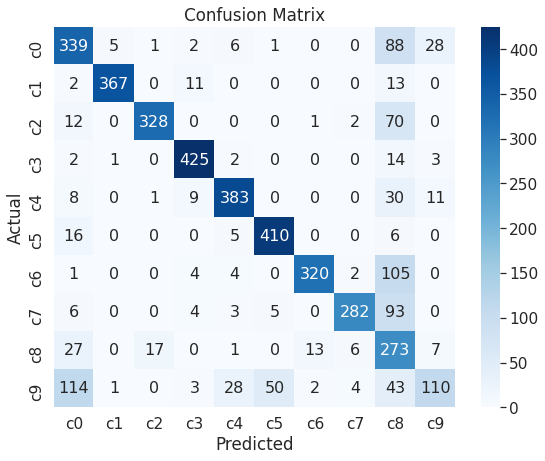

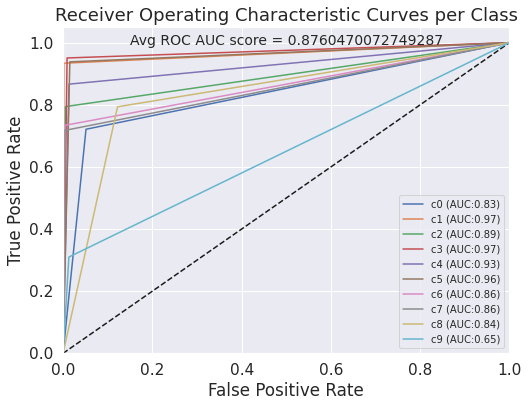

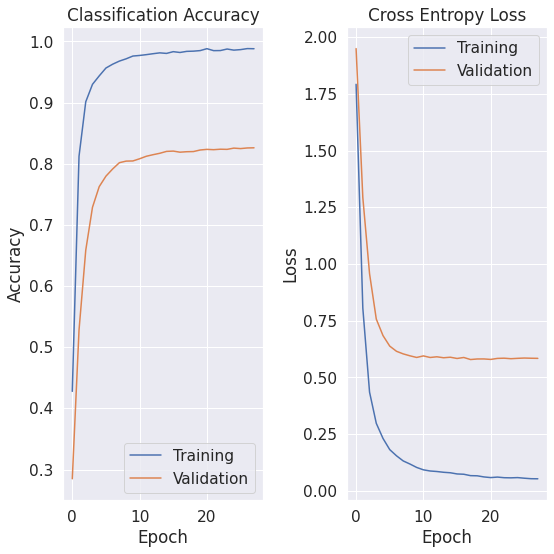

In [0]:
model_eval(mobilenet_model, test_batches, total_test, batch_size, classes)
plot_fit_results(mobilenet_history, len(mobilenet_history.history['loss']))

### InceptionV3

In [0]:
img_height = 299
img_width = 299
color_channels = 3
color_mode = 'rgb'
img_shape = (img_height, img_width, color_channels)
epochs=30
batch_size = 32

In [0]:
train_datagen = ImageDataGenerator(rotation_range=30, 
                                   shear_range=.5, 
                                   zoom_range=.2, 
                                   width_shift_range=.1, 
                                   height_shift_range=.1,
                                   fill_mode='nearest', 
                                   preprocessing_function=inception_v3.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=inception_v3.preprocess_input)

train_batches, valid_batches, test_batches = create_datagen_flows(train_datagen, val_datagen, train_path, valid_path, test_path, img_height, img_width, color_mode, classes, batch_size)

Found 14387 images belonging to 10 classes.
Found 3907 images belonging to 10 classes.
Found 4130 images belonging to 10 classes.


#### First, train the new output block. 

In [0]:
inc_base = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape)

global_average = GlobalAveragePooling2D()
dense_1 = Dense(1024, activation='relu')
dropout_1 = Dropout(0.1)
dense_2 = Dense(1024, activation='relu')
batchnorm_2 = BatchNormalization()
dropout_2 =  Dropout(0.5)
dense_3 = Dense(512, activation='relu')
output = Dense(10, activation='softmax')

inc_model = Sequential([inc_base,
                        global_average,
                        dense_1, 
                        dropout_1, 
                        dense_2, 
                        batchnorm_2, 
                        dropout_2, 
                        dense_3,
                        output])

# freeze pre-trained model layers
inc_base.trainable = False

# tune the new prediction layer
sgd = SGD(lr = 0.001)
inc_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
inc_history = inc_model.fit(train_batches, 
                            steps_per_epoch=total_train//batch_size, 
                            epochs=epochs, 
                            validation_data=valid_batches, 
                            validation_steps=total_val//batch_size, 
                            shuffle=True,
                            callbacks=[(early_stopping, 
                                       model_checkpoint,
                                       learning_rate_scheduler)])

87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 2.3013 - accuracy: 0.2263
Epoch 00001: val_loss did not improve from 0.56420
449/449 [==============================] - 343s 763ms/step - loss: 2.3013 - accuracy: 0.2263 - val_loss: 1.8158 - val_accuracy: 0.3622 - lr: 0.0010
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 1.7163 - accuracy: 0.4056
Epoch 00002: val_loss did not improve from 0.56420
449/449 [==============================] - 338s 754ms/step - loss: 1.7163 - accuracy: 0.4056 - val_loss: 1.5280 - val_accuracy: 0.4639 - lr: 0.0010
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 1.4152 - accuracy: 0.5094
Epoch 00003: val_loss did not improve from 0.56420
449/449 [==============================] - 337s 752ms/step - loss: 1.4152 - accuracy: 0.5094 - val_loss: 1.4153 - val_accuracy: 0.5210 - lr: 0.0010
Epoch 4/30
449/449 [==============================

130/130 [==============================] - 22s 172ms/step
              precision    recall  f1-score   support

          c0       0.48      0.39      0.43       470
          c1       0.87      0.62      0.72       393
          c2       0.57      0.94      0.71       413
          c3       0.91      0.62      0.74       447
          c4       0.88      0.57      0.70       442
          c5       0.47      0.78      0.59       437
          c6       0.84      0.51      0.64       436
          c7       0.70      0.94      0.80       393
          c8       0.38      0.51      0.44       344
          c9       0.50      0.30      0.37       355

    accuracy                           0.62      4130
   macro avg       0.66      0.62      0.61      4130
weighted avg       0.67      0.62      0.62      4130



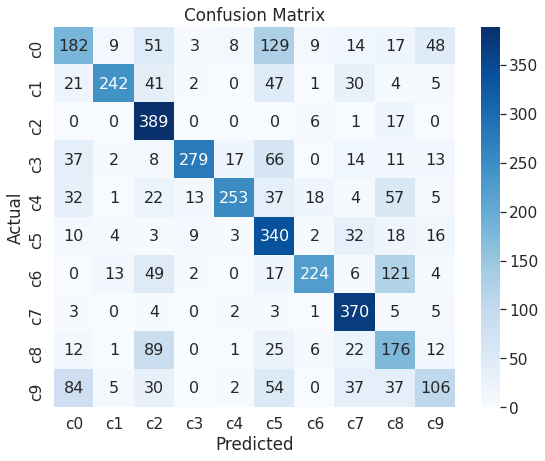

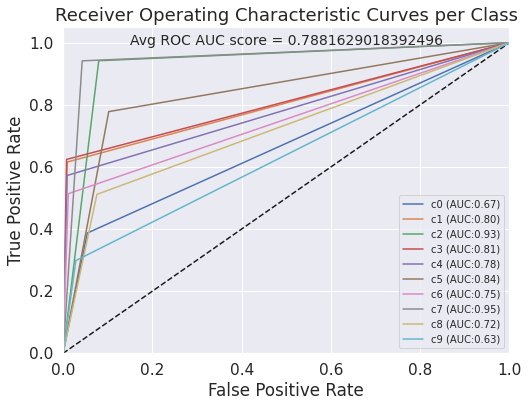

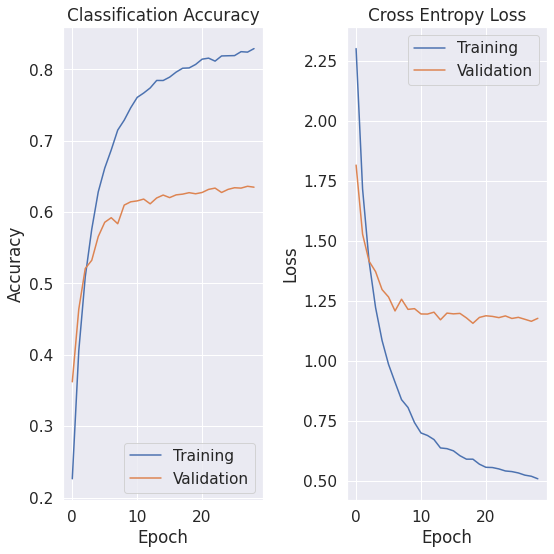

In [0]:
model_eval(inc_model, test_batches, total_test, batch_size, classes)
plot_fit_results(inc_history, len(inc_history.history['loss']))

#### Now tune entire model. 

In [0]:
train_batches.reset()
valid_batches.reset()
test_batches.reset()

inc_base = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape)
global_average = GlobalAveragePooling2D()
dense_1 = Dense(1024, activation='relu')
dropout_1 = Dropout(0.1)
dense_2 = Dense(1024, activation='relu')
batchnorm_2 = BatchNormalization()
dropout_2 =  Dropout(0.5)
dense_3 = Dense(512, activation='relu')
output = Dense(10, activation='softmax')

inc_model = Sequential([inc_base,
                        global_average,
                        dense_1, 
                        dropout_1, 
                        dense_2, 
                        batchnorm_2, 
                        dropout_2, 
                        dense_3,
                        output])
inc_base.trainable = True

sgd = SGD(lr=.001)
inc_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])
inc_all_history = inc_model.fit(train_batches, 
                                steps_per_epoch=total_train//batch_size, 
                                epochs=epochs, 
                                validation_data=valid_batches, 
                                validation_steps=total_val//batch_size, 
                                shuffle=True,
                                callbacks=[(early_stopping, 
                                            model_checkpoint, 
                                            learning_rate_scheduler)])

87916544/87910968 [==============================] - 0s 0us/step
Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 1.9475 - accuracy: 0.3469
Epoch 00001: val_loss improved from inf to 1.37346, saving model to model-01-0.57.hdf5
449/449 [==============================] - 349s 777ms/step - loss: 1.9475 - accuracy: 0.3469 - val_loss: 1.3735 - val_accuracy: 0.5681 - lr: 0.0010
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.7750
Epoch 00002: val_loss improved from 1.37346 to 0.91318, saving model to model-02-0.71.hdf5
449/449 [==============================] - 339s 754ms/step - loss: 0.6957 - accuracy: 0.7750 - val_loss: 0.9132 - val_accuracy: 0.7116 - lr: 0.0010
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 0.3489 - accuracy: 0.8929
Epoch 00003: val_loss improved from 0.91318 to 0.79282, saving model to model-03-0.75.hdf5
449/449 [==============================] - 340s 756ms/step - loss: 0.3489 - accura

130/130 [==============================] - 20s 151ms/step
              precision    recall  f1-score   support

          c0       0.67      0.75      0.71       470
          c1       0.98      0.92      0.95       393
          c2       0.85      0.81      0.83       413
          c3       0.91      0.95      0.93       447
          c4       0.98      0.77      0.86       442
          c5       0.89      0.91      0.90       437
          c6       0.90      0.91      0.90       436
          c7       0.91      0.94      0.92       393
          c8       0.52      0.78      0.62       344
          c9       0.66      0.40      0.50       355

    accuracy                           0.82      4130
   macro avg       0.83      0.81      0.81      4130
weighted avg       0.83      0.82      0.82      4130



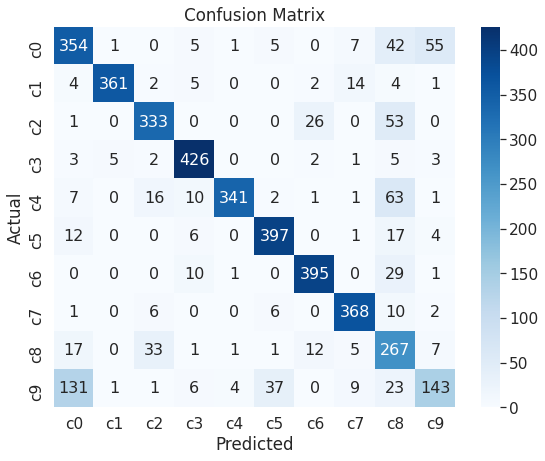

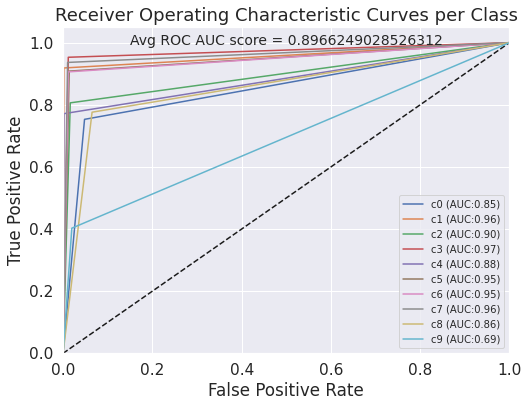

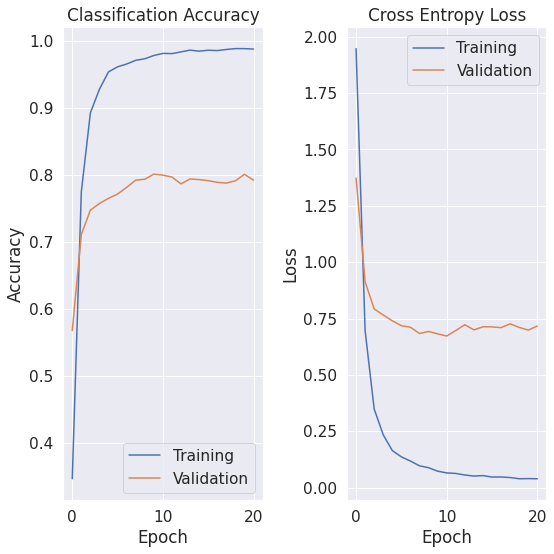

In [0]:
model_eval(inc_model, test_batches, total_test, batch_size, classes)
plot_fit_results(inc_all_history, len(inc_all_history.history['loss']))

#### Now try training the entire model with a simple output block. 

In [0]:
train_batches.reset()
valid_batches.reset()
test_batches.reset()

inc_base = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape)
global_average = GlobalAveragePooling2D()
output = Dense(10, activation='softmax')

inc_model = Sequential([inc_base,
                        global_average,
                        output])
inc_base.trainable = True

sgd = SGD(lr=.001)
inc_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])
inc_all_history = inc_model.fit(train_batches, 
                                steps_per_epoch=total_train//batch_size, 
                                epochs=epochs, 
                                validation_data=valid_batches, 
                                validation_steps=total_val//batch_size, 
                                shuffle=True,
                                callbacks=[(early_stopping, 
                                            model_checkpoint, 
                                            learning_rate_scheduler)])

Epoch 1/30
449/449 [==============================] - ETA: 0s - loss: 2.0672 - accuracy: 0.3370
Epoch 00001: val_loss did not improve from 0.67277
449/449 [==============================] - 346s 771ms/step - loss: 2.0672 - accuracy: 0.3370 - val_loss: 1.8642 - val_accuracy: 0.4209 - lr: 0.0010
Epoch 2/30
449/449 [==============================] - ETA: 0s - loss: 1.3272 - accuracy: 0.7288
Epoch 00002: val_loss did not improve from 0.67277
449/449 [==============================] - 349s 778ms/step - loss: 1.3272 - accuracy: 0.7288 - val_loss: 1.1850 - val_accuracy: 0.6063 - lr: 0.0010
Epoch 3/30
449/449 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.8599
Epoch 00003: val_loss did not improve from 0.67277
449/449 [==============================] - 342s 761ms/step - loss: 0.6885 - accuracy: 0.8599 - val_loss: 0.8102 - val_accuracy: 0.7395 - lr: 0.0010
Epoch 4/30
449/449 [==============================] - ETA: 0s - loss: 0.4191 - accuracy: 0.9115
Epoch 00004: val_lo

130/130 [==============================] - 19s 148ms/step
              precision    recall  f1-score   support

          c0       0.65      0.88      0.75       470
          c1       0.98      0.85      0.91       393
          c2       0.94      0.95      0.94       413
          c3       0.91      0.96      0.94       447
          c4       1.00      0.88      0.93       442
          c5       0.98      0.90      0.94       437
          c6       0.99      0.85      0.91       436
          c7       0.92      0.90      0.91       393
          c8       0.46      0.82      0.59       344
          c9       0.82      0.23      0.36       355

    accuracy                           0.83      4130
   macro avg       0.86      0.82      0.82      4130
weighted avg       0.87      0.83      0.83      4130



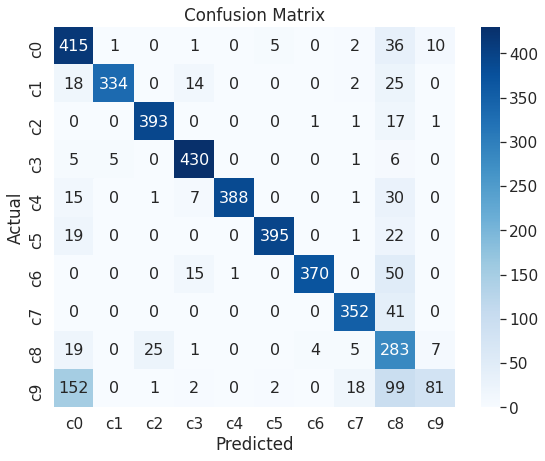

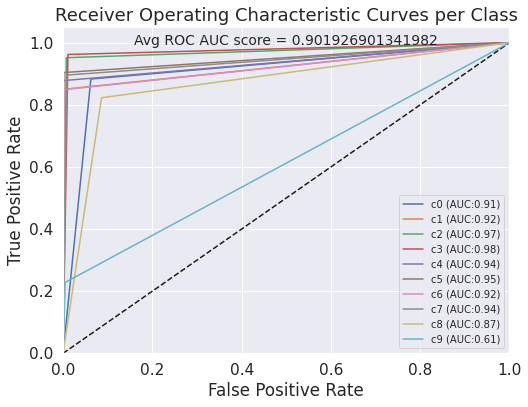

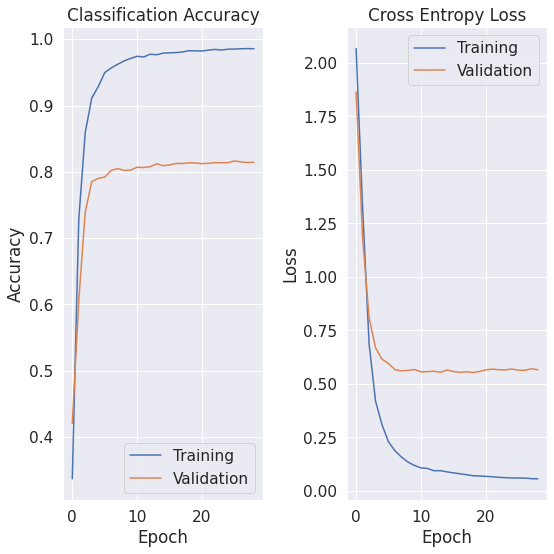

In [0]:
model_eval(inc_model, test_batches, total_test, batch_size, classes)
plot_fit_results(inc_all_history, len(inc_all_history.history['loss']))

### VGG19

In [0]:
img_height = 224
img_width = 224
color_channels = 3
color_mode = 'rgb'
img_shape = (img_height, img_width, color_channels)
epochs=20
batch_size = 32

In [0]:
train_datagen = ImageDataGenerator(rotation_range=30, 
                                   shear_range=.5, 
                                   zoom_range=.2, 
                                   width_shift_range=.1, 
                                   height_shift_range=.1,
                                   fill_mode='nearest', 
                                   preprocessing_function=vgg19.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=vgg19.preprocess_input)

train_batches, valid_batches, test_batches = create_datagen_flows(train_datagen, val_datagen, train_path, valid_path, test_path, img_height, img_width, color_mode, classes, batch_size)

Found 14387 images belonging to 10 classes.
Found 3907 images belonging to 10 classes.
Found 4130 images belonging to 10 classes.


#### First, train the new output block. 

In [0]:
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=img_shape)
global_average = GlobalAveragePooling2D()
dense_1 = Dense(1024, activation='relu')
dropout_1 = Dropout(0.1)
dense_2 = Dense(1024, activation='relu')
batchnorm_2 = BatchNormalization()
dropout_2 =  Dropout(0.5)
dense_3 = Dense(512, activation='relu')
output = Dense(10, activation='softmax')

vgg_model = Sequential([vgg_base,
                        global_average,
                        dense_1, 
                        dropout_1, 
                        dense_2, 
                        batchnorm_2, 
                        dropout_2, 
                        dense_3,
                        output])

# freeze pre-trained model layers
vgg_base.trainable = False

# tune new output layer
sgd = SGD(lr=.001)
vgg_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
vgg_history = vgg_model.fit(train_batches, 
                            steps_per_epoch=total_train//batch_size, 
                            epochs=epochs, 
                            validation_data=valid_batches, 
                            validation_steps=total_val//batch_size, 
                            shuffle=True,
                            callbacks=[(early_stopping, 
                                        model_checkpoint, 
                                        learning_rate_scheduler)])

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/20
449/449 [==============================] - ETA: 0s - loss: 2.4321 - accuracy: 0.2033
Epoch 00001: val_loss did not improve from 0.55318
449/449 [==============================] - 204s 455ms/step - loss: 2.4321 - accuracy: 0.2033 - val_loss: 1.8013 - val_accuracy: 0.3622 - lr: 0.0010
Epoch 2/20
449/449 [==============================] - ETA: 0s - loss: 1.8028 - accuracy: 0.3843
Epoch 00002: val_loss did not improve from 0.55318
449/449 [==============================] - 202s 450ms/step - loss: 1.8028 - accuracy: 0.3843 - val_loss: 1.6059 - val_accuracy: 0.4180 - lr: 0.0010
Epoch 3/20
449/449 [==============================] - ETA: 0s - loss: 1.4891 - accuracy: 0.4914
Epoch 00003: val_loss did not improve from 0.55318
449/449 [==============================] - 202s 450ms/step - loss: 1.4891 - accuracy: 0.4914 - val_loss: 1.5475 - val_accuracy: 0.4388 - lr: 0.0010
Epoch 4/20
449/449 [==============================

130/130 [==============================] - 19s 149ms/step
              precision    recall  f1-score   support

          c0       0.68      0.20      0.31       470
          c1       0.61      0.79      0.69       393
          c2       0.38      0.78      0.51       413
          c3       0.87      0.79      0.83       447
          c4       0.77      0.56      0.65       442
          c5       0.83      0.85      0.84       437
          c6       0.61      0.82      0.70       436
          c7       0.60      0.72      0.65       393
          c8       0.66      0.40      0.50       344
          c9       0.42      0.20      0.27       355

    accuracy                           0.62      4130
   macro avg       0.64      0.61      0.59      4130
weighted avg       0.65      0.62      0.60      4130



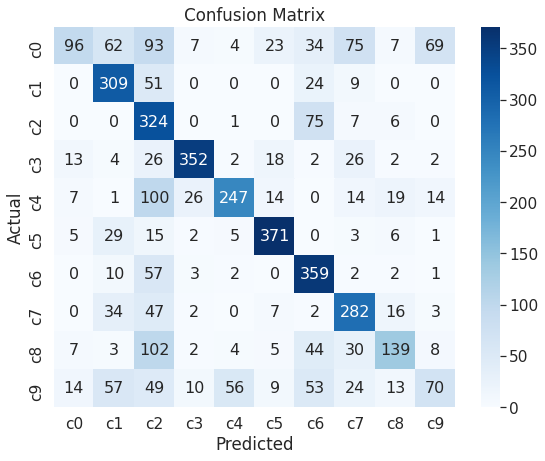

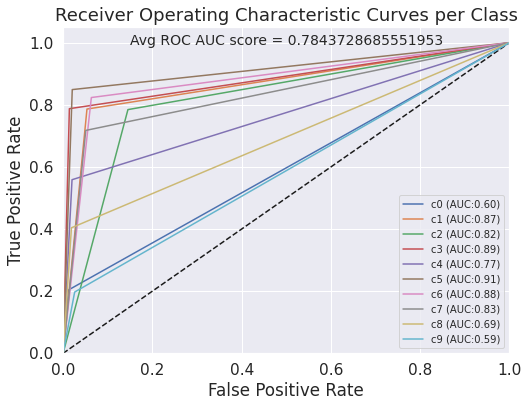

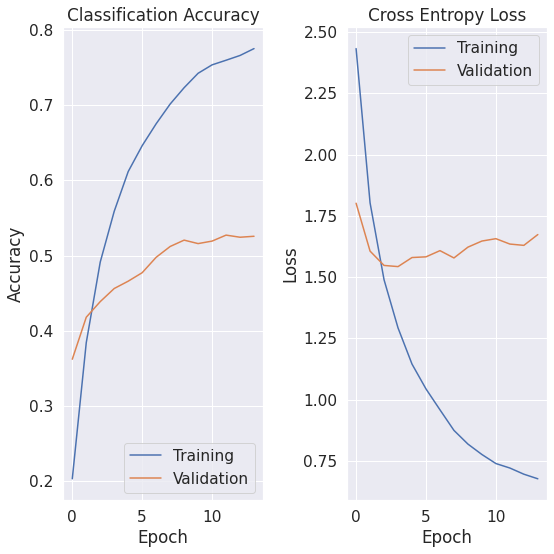

In [0]:
model_eval(vgg_model, test_batches, total_test, batch_size, classes)
plot_fit_results(vgg_history, len(vgg_history.history['loss']))

#### Now tune entire model.

In [0]:
train_batches.reset()
valid_batches.reset()
test_batches.reset()

vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=img_shape)
global_average = GlobalAveragePooling2D()
dense_1 = Dense(1024, activation='relu')
dropout_1 = Dropout(0.1)
dense_2 = Dense(1024, activation='relu')
batchnorm_2 = BatchNormalization()
dropout_2 =  Dropout(0.5)
dense_3 = Dense(512, activation='relu')
output = Dense(10, activation='softmax')

vgg_model = Sequential([vgg_base,
                        global_average,
                        dense_1, 
                        dropout_1, 
                        dense_2, 
                        batchnorm_2, 
                        dropout_2, 
                        dense_3,
                        output])

vgg_base.trainable = True

sgd = SGD(lr=.001)
vgg_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])
vgg_all_history = vgg_model.fit(train_batches, 
                                steps_per_epoch=total_train//batch_size, 
                                epochs=epochs, 
                                validation_data=valid_batches, 
                                validation_steps=total_val//batch_size, 
                                shuffle=True,
                                callbacks=[(early_stopping, 
                                            model_checkpoint, 
                                            learning_rate_scheduler)])

Epoch 1/20
449/449 [==============================] - ETA: 0s - loss: 2.7657 - accuracy: 0.1153
Epoch 00001: val_loss did not improve from 0.55318
449/449 [==============================] - 236s 526ms/step - loss: 2.7657 - accuracy: 0.1153 - val_loss: 2.6461 - val_accuracy: 0.1112 - lr: 0.0010
Epoch 2/20
449/449 [==============================] - ETA: 0s - loss: 1.9541 - accuracy: 0.3031
Epoch 00002: val_loss did not improve from 0.55318
449/449 [==============================] - 236s 526ms/step - loss: 1.9541 - accuracy: 0.3031 - val_loss: 1.6053 - val_accuracy: 0.4621 - lr: 0.0010
Epoch 3/20
449/449 [==============================] - ETA: 0s - loss: 0.6146 - accuracy: 0.8037
Epoch 00003: val_loss did not improve from 0.55318
449/449 [==============================] - 236s 525ms/step - loss: 0.6146 - accuracy: 0.8037 - val_loss: 0.6559 - val_accuracy: 0.7615 - lr: 0.0010
Epoch 4/20
449/449 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.9159
Epoch 00004: val_lo

130/130 [==============================] - 19s 145ms/step
              precision    recall  f1-score   support

          c0       0.73      0.56      0.64       470
          c1       0.95      0.98      0.96       393
          c2       0.93      0.73      0.82       413
          c3       0.91      0.94      0.92       447
          c4       0.99      0.84      0.91       442
          c5       0.93      0.95      0.94       437
          c6       0.91      0.86      0.88       436
          c7       0.79      0.82      0.80       393
          c8       0.41      0.80      0.54       344
          c9       0.60      0.45      0.52       355

    accuracy                           0.80      4130
   macro avg       0.82      0.79      0.79      4130
weighted avg       0.83      0.80      0.80      4130



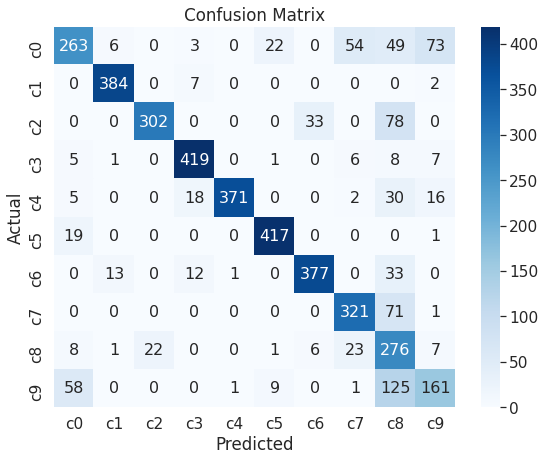

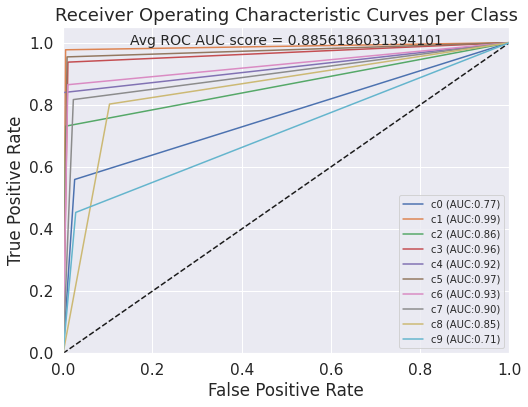

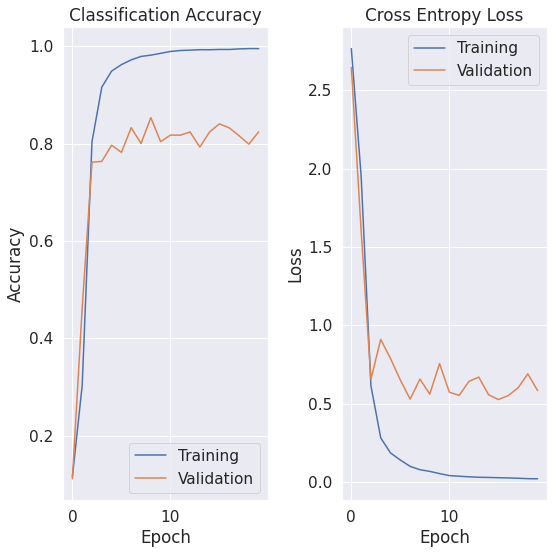

In [0]:
model_eval(vgg_model, test_batches, total_test, batch_size, classes)
plot_fit_results(vgg_all_history, len(vgg_all_history.history['loss']))

#### Now tune entire model with simple output block. 

In [0]:
train_batches.reset()
valid_batches.reset()
test_batches.reset()

vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=img_shape)
global_average = GlobalAveragePooling2D()
output = Dense(10, activation='softmax')

vgg_model = Sequential([vgg_base,
                        global_average,
                        output])

vgg_base.trainable = True

sgd = SGD(lr=.001)
vgg_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])
vgg_all_history = vgg_model.fit(train_batches, 
                                steps_per_epoch=total_train//batch_size, 
                                epochs=epochs, 
                                validation_data=valid_batches, 
                                validation_steps=total_val//batch_size, 
                                shuffle=True,
                                callbacks=[(early_stopping, 
                                            model_checkpoint, 
                                            learning_rate_scheduler)])

Epoch 1/20
449/449 [==============================] - ETA: 0s - loss: 0.9570 - accuracy: 0.6763
Epoch 00001: val_loss did not improve from 0.52662
449/449 [==============================] - 233s 520ms/step - loss: 0.9570 - accuracy: 0.6763 - val_loss: 0.9209 - val_accuracy: 0.7992 - lr: 0.0010
Epoch 2/20
449/449 [==============================] - ETA: 0s - loss: 0.1598 - accuracy: 0.9537
Epoch 00002: val_loss did not improve from 0.52662
449/449 [==============================] - 234s 521ms/step - loss: 0.1598 - accuracy: 0.9537 - val_loss: 0.6090 - val_accuracy: 0.8581 - lr: 0.0010
Epoch 3/20
449/449 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9746
Epoch 00003: val_loss did not improve from 0.52662
449/449 [==============================] - 235s 523ms/step - loss: 0.0868 - accuracy: 0.9746 - val_loss: 0.7752 - val_accuracy: 0.8158 - lr: 0.0010
Epoch 4/20
449/449 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9826
Epoch 00004: val_lo

130/130 [==============================] - 19s 149ms/step
              precision    recall  f1-score   support

          c0       0.69      0.66      0.68       470
          c1       0.97      0.93      0.95       393
          c2       0.97      0.69      0.80       413
          c3       0.91      0.97      0.94       447
          c4       0.98      0.88      0.93       442
          c5       0.96      0.96      0.96       437
          c6       0.92      0.92      0.92       436
          c7       0.79      0.92      0.85       393
          c8       0.54      0.89      0.67       344
          c9       0.58      0.40      0.48       355

    accuracy                           0.83      4130
   macro avg       0.83      0.82      0.82      4130
weighted avg       0.84      0.83      0.82      4130



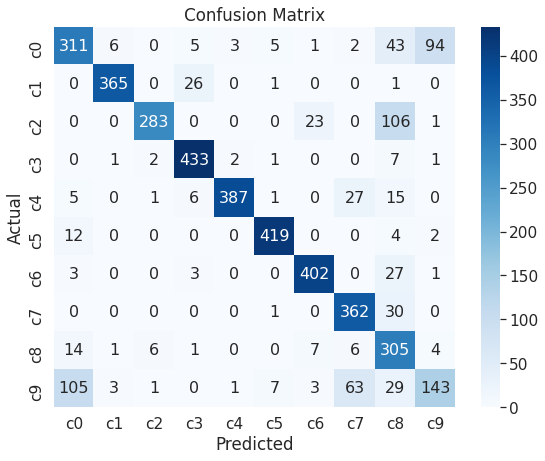

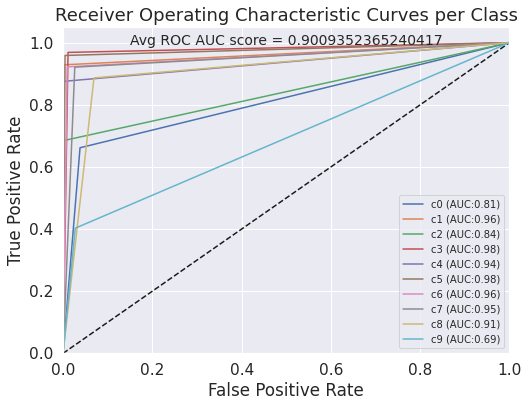

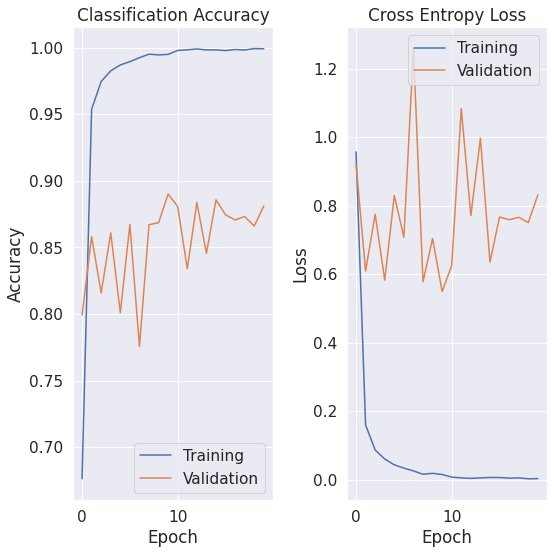

In [0]:
model_eval(vgg_model, test_batches, total_test, batch_size, classes)
plot_fit_results(vgg_all_history, len(vgg_all_history.history['loss']))

# Summary

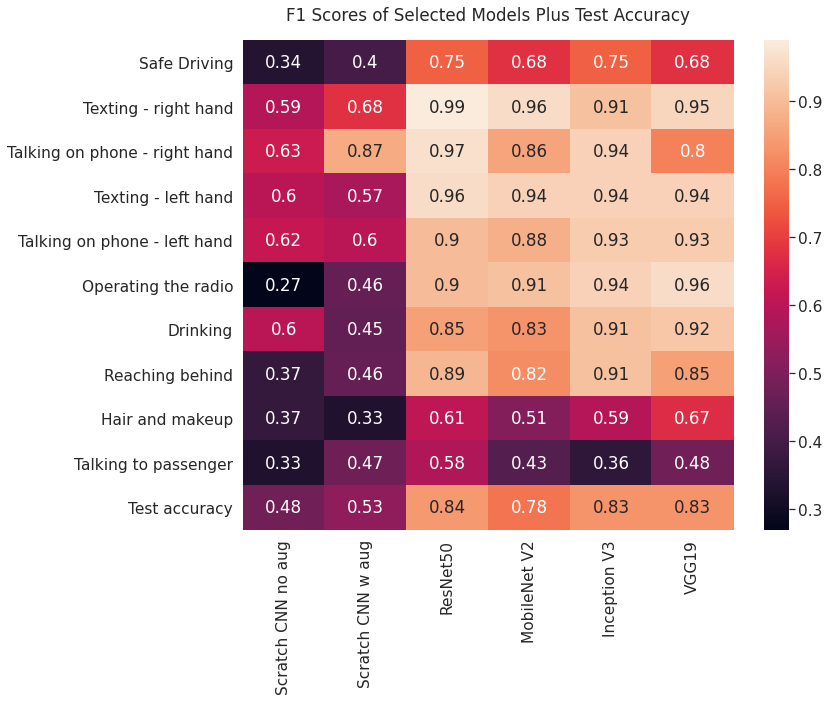

In [25]:
f1_by_class_and_model = pd.DataFrame({'Scratch CNN no aug': {'c0': 0.34, 'c1':  0.59, 'c2':  0.63, 'c3': 0.60, 'c4': 0.62, 'c5': 0.27, 'c6': 0.60, 'c7': 0.37, 'c8':  0.37, 'c9':  0.33, 'acc': 0.48},
                                      'Scratch CNN w aug': {'c0': 0.40, 'c1': 0.68, 'c2': 0.87, 'c3': 0.57, 'c4': 0.60, 'c5': 0.46, 'c6': 0.45, 'c7': 0.46, 'c8': 0.33, 'c9': 0.47, 'acc': 0.53},
                                      'ResNet50': {'c0': 0.75, 'c1': 0.99, 'c2': 0.97, 'c3': 0.96, 'c4': 0.90, 'c5': 0.90, 'c6':  0.85, 'c7': 0.89, 'c8': 0.61, 'c9': 0.58, 'acc': 0.84}, 
                                      'MobileNet V2': {'c0': 0.68, 'c1':  0.96, 'c2':  0.86, 'c3': 0.94, 'c4': 0.88, 'c5': 0.91, 'c6':  0.83, 'c7': 0.82, 'c8':  0.51, 'c9':  0.43, 'acc': 0.78}, 
                                      'Inception V3': {'c0': 0.75, 'c1':  0.91, 'c2':  0.94, 'c3': 0.94, 'c4': 0.93, 'c5': 0.94, 'c6': 0.91, 'c7': 0.91, 'c8':  0.59, 'c9':  0.36, 'acc': 0.83}, 
                                      'VGG19': {'c0': 0.68, 'c1':  0.95, 'c2':  0.80, 'c3': 0.94, 'c4': 0.93, 'c5': 0.96, 'c6': 0.92, 'c7': 0.85, 'c8':  0.67, 'c9':  0.48, 'acc': 0.83}})

f1_df = pd.DataFrame.from_dict(f1_by_class_and_model)
plt.figure(figsize = (11,9))
g = sns.heatmap(f1_df, annot=True)
g.set_yticklabels(['Safe Driving', 'Texting - right hand', 'Talking on phone - right hand', 'Texting - left hand', 'Talking on phone - left hand', 'Operating the radio', 'Drinking', 'Reaching behind', 'Hair and makeup', 'Talking to passenger', 
                   'Test accuracy'], rotation=0)
plt.title('F1 Scores of Selected Models Plus Test Accuracy', pad=20)
plt.show()